<h1><center>Алгоритм искусственных водорослей</center></h1> 
<h1><center>(Artificial Algae Algorithm)</center></h1>

Данный алгоритм был вдохновлен поведением фотосинтезирующих одноклеточных водорослей, которые движутся к солнцу. 

Глобальный минимум - точка, в которой волдоросли могут получить больше всего солнечной энергии.
В процессе движения водоросли сталкиваются с споротивлением жидкости. клетки имеют разные размеры. 

Алгоритм состоит из 3-х основных частей: *адаптация*, *эволюция*, *спиральное движение*. 

- **Эволюция**

При достаточных питательных условиях, если колония водорослей получает достаточно света, она растет и размножается (т.е. создаются новые клетки водорослей). Напротив, колония водорослей, не получающая достаточно света, выживает некоторое время, но в конце концов погибает. 

Эволюционный процесс оценивается по приспособленности водорослевой клетки.  
(см. функцию "tournament_selection")

- **Адаптация**

Колония водорослей, которая не может расти в достаточной степени в той или иной среде, пытается приспособиться к окружающей среде, и в результате доминирующий вид меняется. Этот процесс завершается изменением уровня голода в алгоритме. 

Начальное значение уровня голода равно нулю для каждой искусственной водоросли. Величина голодания увеличивается с течением времени t, когда клетка водоросли получает недостаточное количество света. Искусственная водоросль, имеющая наибольшее значение голодания, адаптируется.

- **Спиральное движение**

Клетки водорослей плавают по спирали в жидкости с помощью своих жгутиков, это продемонстрировано н аизображении ниже.

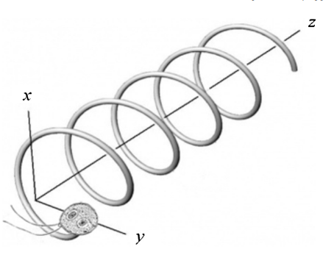

Движения клеток водорослей различны. По мере увеличения поверхности трения растущей водорослевой клетки, частота спиралевидных движений увеличивается за счет увеличения их способности к локальному поиску. Каждая водорослевая клетка может перемещаться пропорциональна ее энергии. Энергия водорослевой клетки в момент времени t прямо пропорциональна количеству поглощенных питательных веществ за это время. Поэтому чем ближе водорослевая клетка к поверхности, тем больше у нее энергии, и она находит больше возможностей двигаться внутри жидкости. Напротив, если поверхность трения меньше, расстояние их перемещения в жидкости больше. Поэтому их способность к глобальному поиску больше. 

Поверхность трения водорослевой клетки об жидкость предсатвляет собой полусферу и задается формулой: 

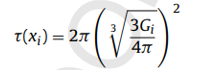

(Формула в нашем алгоритме "calculate_friction")

Геликолиальное движение задается 3-мя уравнениями, одно из них обеспечивает линейное движение (16), а два других угловое (17, 18): 



<h3><center>Псевдокод алгоритма ААА</center></h3>

<h3><center>Реализация</center></h3>

In [1]:
import time
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import optuna
import pandas as pd
from tabulate import tabulate
from matplotlib import cm
import numpy as np
import random
import math

from solution import solution
import transfer_functions_benchmark

<h3><center>Целевые функции</center></h3>


В данной работе будут использоваться следующие функции: 
- Растригина 
- Химмельблау
- Розенброка
- "Подставка для яиц" (Egg holder)

#### Вспомогательная функция для отображения графиков (2D, 3D)

In [2]:
class AbstractTestingFunction(ABC):
    i=0 # Инициализация счетчика изображений

    def __init__(self, **kwargs):
        super().__init__()


    def __call__(self, x):
        return NotImplementedError()
    
    
    
    def plot_2d(self, points=[], dirs=[]):
        # Нахождение максимальных и минимальных значений для точек 
        dx_max = np.max(points[:, 0])
        dy_max = np.max(points[:, 1])

        dx_min = np.min(points[:, 0])
        dy_min = np.min(points[:, 1])

        d_min = min(dx_min, dy_min)
        d_max = max(dx_max, dy_max)

        d_min = min(-1, d_min) # Установка минимального и максимального значения [-1,1]
        d_max = max(1, d_max)

        # Сетка для контура функции
        X = np.arange(d_min, d_max + (d_max - d_min) / 50., (d_max - d_min) / 50.)
        Y = np.arange(d_min, d_max + (d_max - d_min) / 50., (d_max - d_min) / 50.)

        XY_plate = np.transpose([np.tile(X, len(Y)), np.repeat(Y, len(X))])
        
        # Вычисление значение Z для каждой точки Z
        Z = self.__call__(XY_plate)
        Z = np.reshape(Z, (len(X), len(Y)))


        # Отрисовка контура графика
        pl = plt.contourf(X, Y, Z)
        plt.colorbar(pl, shrink=0.5, aspect=5)

        # Отрисовка точек на графике 
        plt.scatter(points[:, 0], points[:, 1], c='r')

        # Отрисовка направлений 
        for dir_vector, point in zip(dirs, points):
            plt.quiver(point[0], point[1], dir_vector[0], dir_vector[1])

        plt.savefig(f"gifs/{self.i}.jpg") 

        self.i += 1

        plt.show()

    def plot_3d(self, points=[], d=10):
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')

        # Make data.
        dx_max = np.max(points[:, 0])
        dy_max = np.max(points[:, 1])

        dx_min = np.min(points[:, 0])
        dy_min = np.min(points[:, 1])

        d_min = min(dx_min, dy_min)
        d_max = max(dx_max, dy_max)

        d_min = min(-1, d_min)
        d_max = max(1, d_max)


        X = np.arange(d_min, d_max + (d_max - d_min) / 50., (d_max - d_min) / 50.)
        Y = np.arange(d_min, d_max + (d_max - d_min) / 50., (d_max - d_min) / 50.)

        XY_plate = np.transpose([np.tile(X, len(Y)), np.repeat(Y, len(X))])

        Z = self.__call__(XY_plate)
        Z = np.reshape(Z, (len(X), len(Y)))
        X, Y = np.meshgrid(X, Y)

    
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)


        fig.colorbar(surf, shrink=0.5, aspect=5)


        ax.scatter(points[:, 0], points[:, 1], self.__call__(points), c='g')

        plt.show()

#### Функция Растригина

In [3]:
class Rastrigin(AbstractTestingFunction):

    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.A = kwargs.get('A', 10)

    def __call__(self, x, dim=None):
        """
        x: vector of input values
        """
        if dim is None:
            dim = self.dim
        d = dim
        return self.A * d + np.sum(x * x - self.A * np.cos(2 * np.pi * x), axis=-1)
    
    def plot_3dd(self):

        X = np.linspace(-5.12, 5.12, 400)
        Y = np.linspace(-5.12, 5.12, 400)
        X, Y = np.meshgrid(X, Y)
        Z = self.__call__(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

In [4]:
#![5.png](attachment:5.png) 

<img src="image/5.png" width="500" height="400">

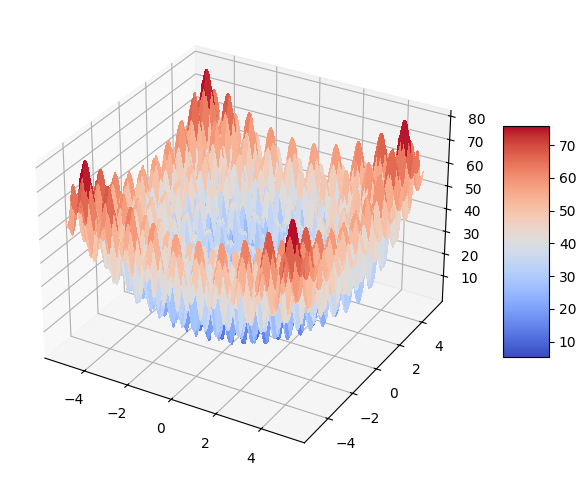

In [5]:
rastrigin_3d = Rastrigin(2)
rastrigin_3d.plot_3dd()

#### Функция Химмельблау

In [6]:
class Himmelblau(AbstractTestingFunction):

    def __call__(self, x):
        """
        x: vector of input values
        """
        x1 = x[..., 0]
        x2 = x[..., 1]
        return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

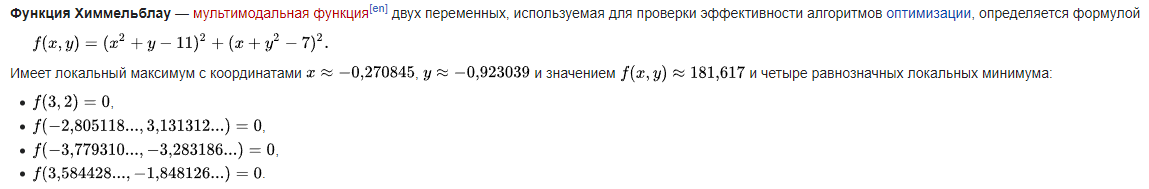

<img src="image/8.png" width="500" height="400">

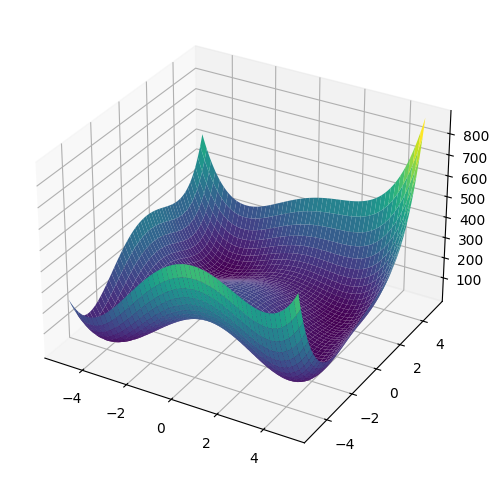

In [7]:
himmelblau_3d = Himmelblau()

x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)

Z = himmelblau_3d(np.stack([X, Y], axis=-1))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

plt.show()

#### Функция Розенброка

In [8]:
class Rosenbrock(AbstractTestingFunction):

    def __call__(self, x):
        """
        x: vector of input values
        """
        return np.sum(100.0*(x[..., 1:] - x[..., :-1]**2.0)**2.0 + (1 - x[..., :-1])**2.0, axis=-1)

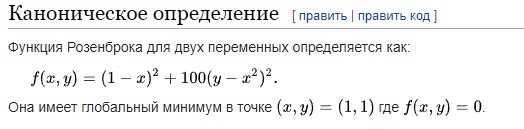

<img src="image/10.png" width="500" height="400">

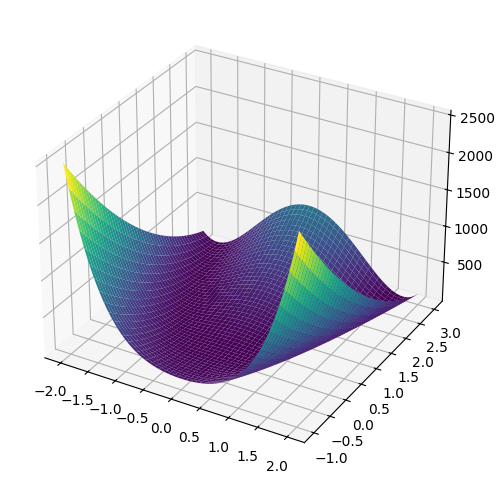

In [9]:
rosenbrock_3d = Rosenbrock()

x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock_3d(np.stack([X, Y], axis=-1))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

plt.show()

#### Функция "Подставки для яиц" (Egg holder)

In [10]:
class EggHolder(AbstractTestingFunction):

    def __call__(self, x):
        """
        x: vector of input values
        """
        x1 = x[..., 0]
        x2 = x[..., 1]
        term1 = -(x2 + 47) * np.sin(np.sqrt(abs(x2 + x1 / 2 + 47)))
        term2 = -x1 * np.sin(np.sqrt(abs(x1 - (x2 + 47))))
        return term1 + term2

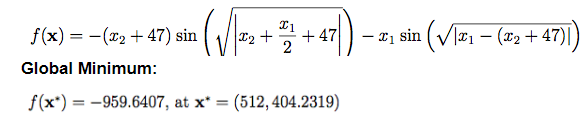

<img src="image/12.png" width="500" height="400">

In [11]:
eggholder_3d = EggHolder()

x = np.linspace(-512, 512, 800)
y = np.linspace(-512, 512, 800)
X, Y = np.meshgrid(x, y)
Z = eggholder_3d(np.stack([X, Y], axis=-1))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

plt.show()

<h3><center>Алгоритм</center></h3>

#### Вспомогательные функции для работы алгоритма

##### Вычисление лучшего агента

In [12]:
def calculate_greatness(greatness, fitness_array1):
    # Нормализация массива fitness_array1. 
    # Вычитаем минимальное значение из всех элементов, делаем деление на разность максимального и минимального значений,
    # чтобы привести значения к диапазону [0, 1].
    normalized_fitness = (fitness_array1 - np.min(fitness_array1)) / (np.max(fitness_array1) - np.min(fitness_array1))
    # Инвертируем значения, чтобы привести их к диапазону [1, 0].
    normalized_fitness = 1 - normalized_fitness
    
    # Проходимся по всем элементам массива greatness
    for i in range(len(greatness)):
        # Рассчитываем половину абсолютного значения текущего элемента greatness.
        fKs = abs(greatness[i] / 2)
        # Вычисляем метрику M, используя нормализованное значение пригодности и fKs.
        # Это формула, включающая в себя нормализованное значение пригодности и величину, 
        # обратно пропорциональную абсолютной величине элемента greatness.
        M = normalized_fitness[i] / (fKs + normalized_fitness[i])
        # Вычисляем прирост для текущего элемента greatness, умножая его на метрику M.
        dX = M * greatness[i]
        # Обновляем текущий элемент массива greatness, добавляя вычисленный прирост.
        greatness[i] += dX


##### Вычисление энергии

In [13]:
def calculate_energy(greatness):
    # Получение отсортированных индексов
    sorting_indices = np.argsort(greatness)
    
    # Создание массива "энергетических уровней" на основе квадратов индексов
    fGreat_surface = np.arange(len(greatness))**2
    
    # Присваивание "энергетических уровней" согласно отсортированным индексам
    fGreat_surface_sorted = fGreat_surface[sorting_indices.argsort()]
    
    # Нормализация "энергетических уровней"
    fGreat_surface_normilized = (fGreat_surface_sorted - fGreat_surface_sorted.min()) / (fGreat_surface_sorted.max() - fGreat_surface_sorted.min())
    
    return fGreat_surface_normilized

##### Вычисление трения (потери энергии на трение)

In [14]:
def calculate_friction(alg_size_matrix):
    # Вычисление радиусов в векторизованной форме
    r = ((alg_size_matrix * 3) / (4 * np.pi)) ** (1/3)
    # Вычисление площади поверхности сфер
    fGreat_surface = 2 * np.pi * (r**2)
    # Нормализация площади поверхности
    fGreat_surface_normalized = (fGreat_surface - fGreat_surface.min()) / (fGreat_surface.max() - fGreat_surface.min())

    return fGreat_surface_normalized

##### "Соревнование двух агентов"

In [15]:
def tournament_selection(fitness_array):

    individual1=random.randint(0,len(fitness_array)-1)
    individual2=random.randint(0,len(fitness_array)-1)

    while individual1==individual2:
        individual2=random.randint(0,len(fitness_array)-1)

    if (fitness_array[individual1] < fitness_array[individual2]):
        return individual1
    else:
        return individual2

#### Алгоритм Искусственных водорослей

#### Гиперпараметры


In [16]:
PopulationSize = 40  # Размер популяции
Iterations= 100      # Количество итераций алгоритма
s_force = 0.8          # Сила сдвига, влияет на величину изменений агента
e_loss = 0.01         # Параметр потери энергии, влияет на уменьшение энергии агента при неуспешных попытках
ap = 0.9             # Параметр адаптации, вероятность изменения агента в сторону лучшего
lb = -5.12
ub = 5.12
dim = 3

In [34]:
def AAA(objf, lb, ub, dim, SearchAgents_no, Max_iter, testing_function, s_force, e_loss, ap):
    
    # Начальные установки
    iter=Max_iter # Начальное количество итераций для использования в графике сходимости
    Max_iter = Max_iter * SearchAgents_no # Максимальное коичество итераций

    # Инициализация

    starveAlg=np.zeros(SearchAgents_no,'int') # Массив для отслеживания голода
    alg_size_matrix=np.ones(SearchAgents_no) # Массив для хранения размера агентов
    ALG = np.random.uniform(lb, ub, size=(SearchAgents_no, dim)) # Начальные позиции агентов 
    fitness_array = np.zeros(SearchAgents_no) # Оценка приспособленности агентов
    s_force = s_force
    e_loss = e_loss
    ap = ap
 
    # Вычисление начальной приспособленности агентов 
    for i in range(0,SearchAgents_no): 
        fitness_array[i] = objf(ALG[i, :],  dim)

    # Нахождение лучшего решения в начальной популяции
    min_fit = min(fitness_array) # минимальное значение фитнесс - функции
    min_fit_index= np.argmin(fitness_array) # индекс агента с минимальным значением фитнесс - функции
    best_ALG = ALG[min_fit_index,:].copy() # копия массива "ALG"
    best_fit = min_fit # Лучшее значение - минимальное значение 

    # Расчет величины агентов
    calculate_greatness(alg_size_matrix,fitness_array.copy())


    convergence_curve1 = np.zeros(iter) # Кривая сходимости

    s = solution() # Объект для хранения результатов
    print("AAA is optimizing  \"" + objf.__name__ + "\"")
    timerStart = time.time() 
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    c = SearchAgents_no # Счетчик общего количества оценок функции
    convergence_curve1[0] = best_fit # Запись начального лучшего значения приспособленности

    t=1 # Индекс для обновления кривой сходимости
    while c < Max_iter: # здесь c изменить на iterations =0

        energy = calculate_energy(alg_size_matrix.copy()) # Расчет энергии и трения агентов
        alg_friction = calculate_friction(alg_size_matrix.copy())

        # Цикл по всем агентам
        for i in range(SearchAgents_no):
            istarve = 0 # Переменая для отслеживания успеха изменения агента
            # Пока у агента есть энергия и не достигнут максимум итераций
            while(energy[i] >= 0 and c < Max_iter):
                neighbor=tournament_selection(fitness_array.copy()) # Выбор соседа для спаринга

                # проверка, что сосед не является самим агентом
                while neighbor==i :
                    neighbor=tournament_selection(fitness_array)

                # Выбираем случайные измерения для изменения 
                dimension_1=random.randint(0,dim-1)
                dimension_2=random.randint(0,dim-1)
                dimension_3=random.randint(0,dim-1)
                while(dimension_1 == dimension_2 or dimension_1 == dimension_3 or dimension_2==dimension_3):
                    dimension_2=random.randint(0,dim-1)
                    dimension_3=random.randint(0,dim-1)

                # Создаем нового агента путем изменения его позиции
                new_alg=ALG[i,:].copy()

                # Применяем изменения к выбранным измерениям
                new_alg[dimension_1] = new_alg[dimension_1] + (ALG[neighbor, dimension_1] - new_alg[dimension_1]) * (s_force - alg_friction[i]) * ((random.random() - 0.5) * 2) 
                new_alg[dimension_2] = new_alg[dimension_2] + (ALG[neighbor, dimension_2] - new_alg[dimension_2]) * (s_force - alg_friction[i]) *  math.cos(random.random() * 360)
                new_alg[dimension_3] = new_alg[dimension_3] + (ALG[neighbor, dimension_3] - new_alg[dimension_3]) * (s_force - alg_friction[i]) *  math.sin(random.random() * 360)

                # Вычисляем приспособленность нового агента    
                new_alg_fit = objf(new_alg, dim)
                energy[i] = energy[i] - e_loss/2 # Уменьшаем энергию агента 


                # Если новый агент лучше текущего 
                if( new_alg_fit < fitness_array[i] ): # если приспособленность "new_alg_fit" меньше чем текущая приспособленность 
                    ALG[i,:] = new_alg.copy() # то новый вариант становится текущем решением
                    fitness_array[i] = new_alg_fit # приспособленность агента обновляется до значения приспособленности нового варианта
                    istarve = 1 # сбрасывается счетчик голода
                else:
                    energy[i] = energy[i] - e_loss/2 # Дополнительно уменьшаемэнергию за неуспешную попытку


                # Обновляем лучшее решение, если найдено
                value = min(fitness_array)
                index = np.argmin(fitness_array)
                if value < best_fit:
                    best_fit = value
                    best_ALG = ALG[index, :].copy()
                    min_fit_index = index

                # Увеличиваем счетчик оценок функции 
                c=c+1
                if (c % SearchAgents_no == 0):
                    convergence_curve1[t] = best_fit # Обновляем кривую сходимости 
                    t = t + 1
                    
                if c % 100 == 0:
                    testing_function.plot_2d(points=ALG) # Визуализация текущей позиции агентов
            
                        
            # Увеличиваем счетчик голода, если изменение не было успешным
            if istarve==0:
                starveAlg[i]= starveAlg[i] + 1

        #Процесс эволюции ----- #Процесс эволюции ----- #Процесс эволюции ----- #
        calculate_greatness(alg_size_matrix, fitness_array.copy())
        rand_dim=random.randint(0,dim-1)
        minindex = np.argmin(alg_size_matrix)
        maxindex = np.argmax(alg_size_matrix)
        ALG[minindex,rand_dim] = ALG[maxindex,rand_dim]
        #Процесс эволюции ----- #Процесс эволюции ----- #Процесс эволюции ----- #


        #Процесс адаптации ----- #Процесс адаптации ----- #Процесс адаптации ----- #
        index3 = np.argmax(starveAlg)
        if random.random() < ap :
            for i in range(dim):
                ALG[index3, i] = ALG[index3, i] +  ( best_ALG[i] - ALG[index3,i] ) * random.random()
                ss = transfer_functions_benchmark.s1(ALG[index3, i])
                if (random.random() < ss):
                    ALG[index3, i] = 1
                else:
                    ALG[index3, i] = 0
        #Процесс адаптации ----- # Процесс адаптации ----- # Процесс адаптации ----- #

        if (c % Max_iter == 0):
            
            print(['At iteration ' + str(c/SearchAgents_no) + ' the best fitness is ' + str(best_fit)])

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence_curve1 = convergence_curve1
    s.optimizer = "AAA"
    s.objfname = objf.__name__
    s.bestIndividual = best_ALG

    print(f'Координаты лучшего агента: {best_ALG}')
    testing_function.plot_3d(points=ALG) # Визуализация текущей позиции агентов

    plt.figure(figsize=(10, 6))
    plt.plot(convergence_curve1, label='Кривая приспособленности')
    plt.xlabel('Итерации')
    plt.ylabel('Значение приспособленности')
    plt.title('График сходимости для AAA')
    plt.legend()
    plt.grid(True)
    plt.show()

    return s


#### "Вспомогательные обертки для отображения функций в размерности"

In [35]:
rastrigin = Rastrigin(dim=3) 
def rastrigin_wrapper(x, dim=3):
    rastrigin = Rastrigin(dim=dim)
    return rastrigin(x)

himmelblau = Himmelblau()
def himmelblau_wrapper(x, dim=None):
    return himmelblau(x)

rosenbrock = Rosenbrock()
def rosenbrock_wrapper(x, dim = None):
    return rosenbrock(x)

egg_holder = EggHolder()
def egg_holder_wrapper(x, dim = None):
    return egg_holder(x)

### Проверка алгоритма на разных функциях с вариацией гиперпараметров

#### Запуск алгоритма с функцией Растригина:

<img src="image/6.png">

AAA is optimizing  "rastrigin_wrapper"


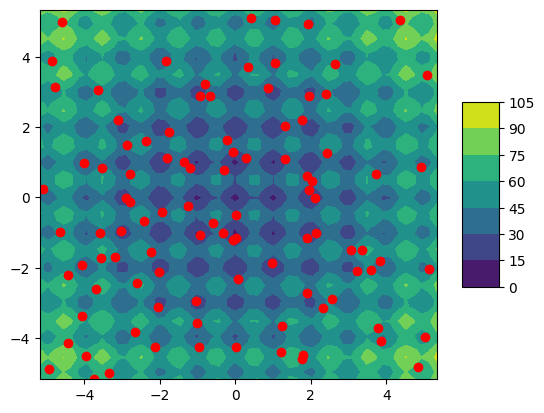

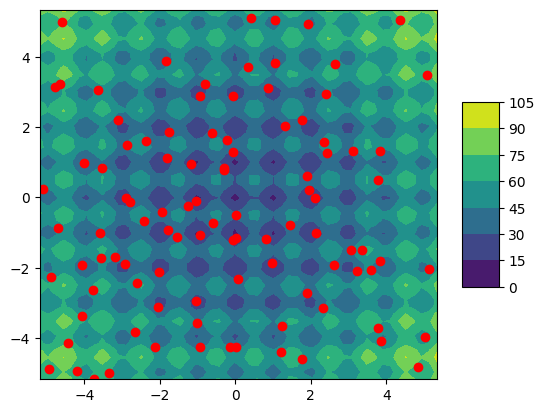

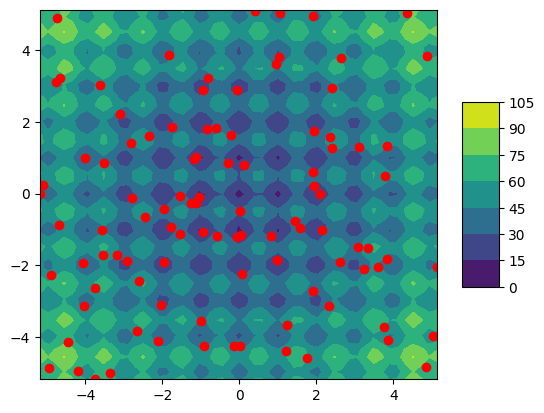

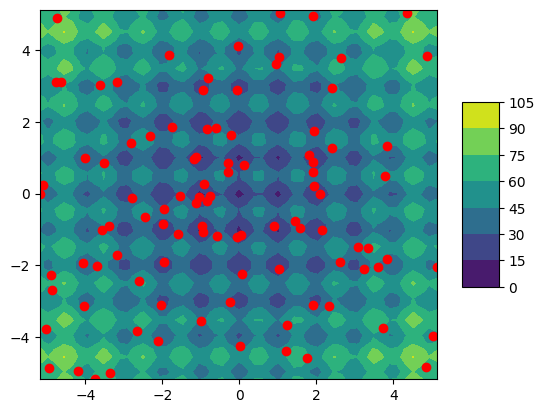

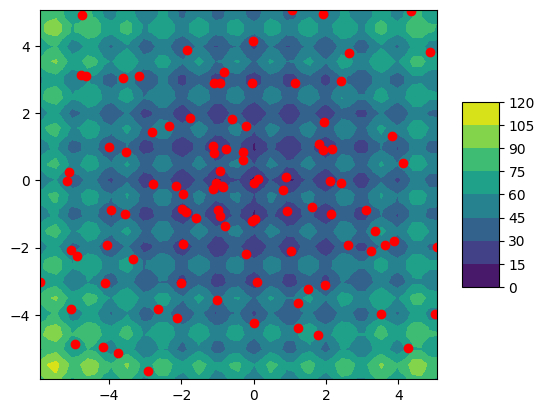

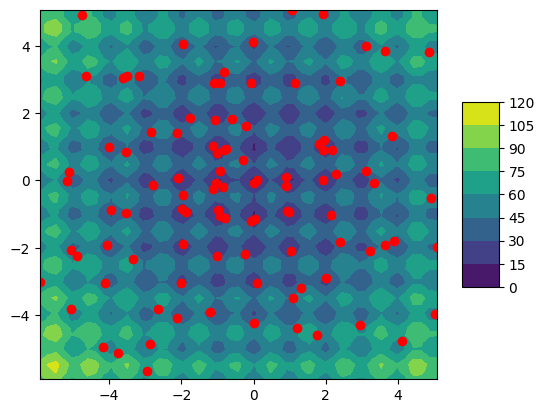

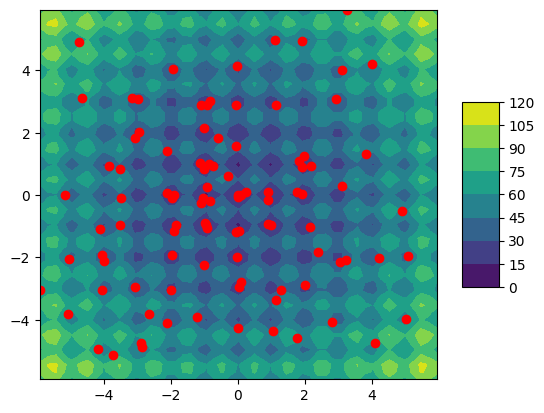

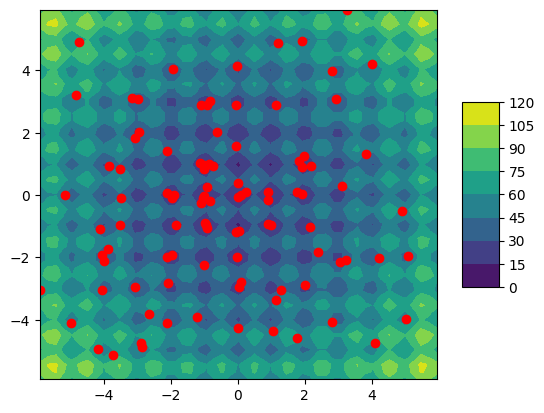

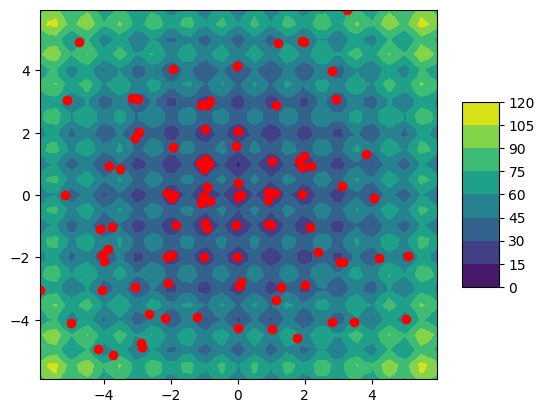

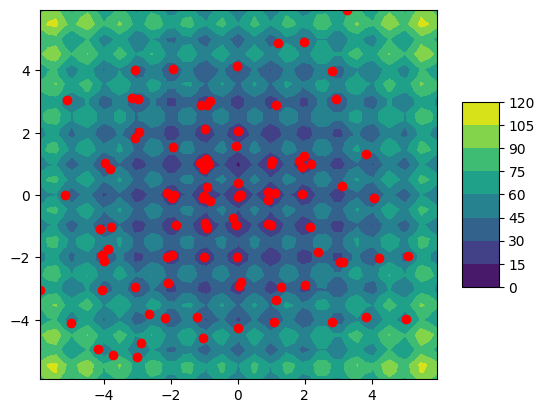

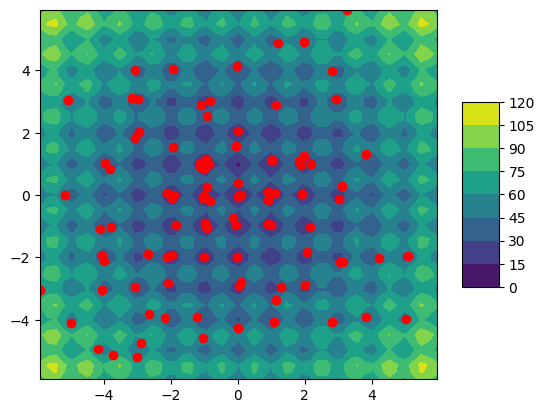

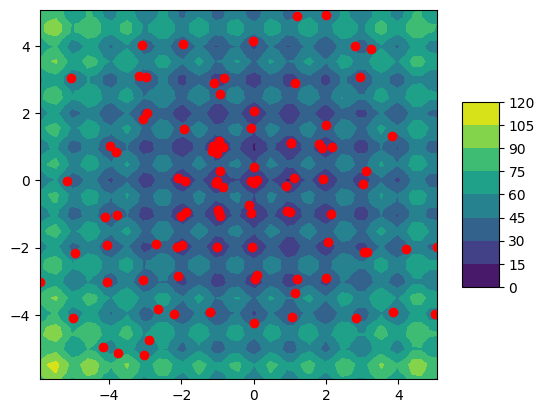

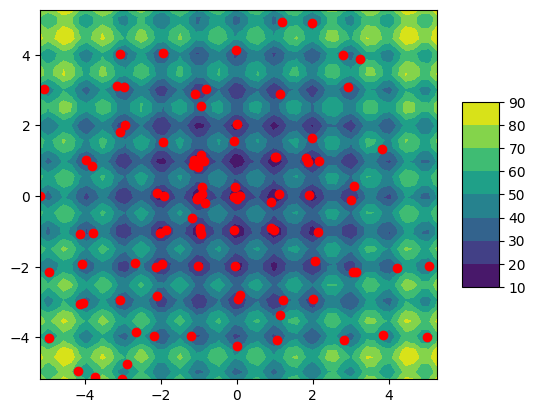

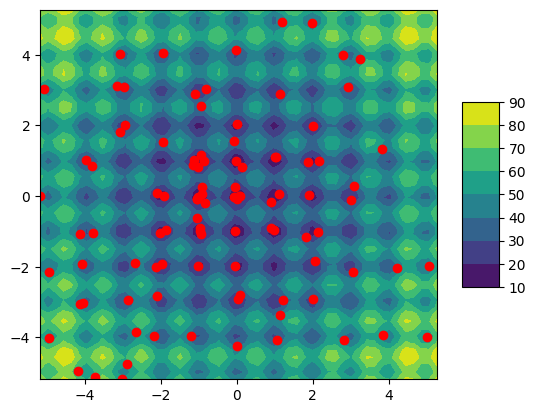

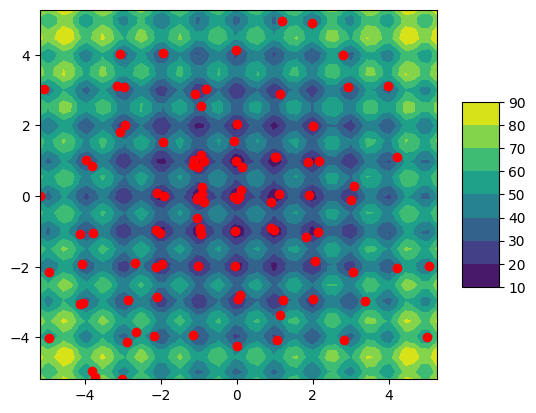

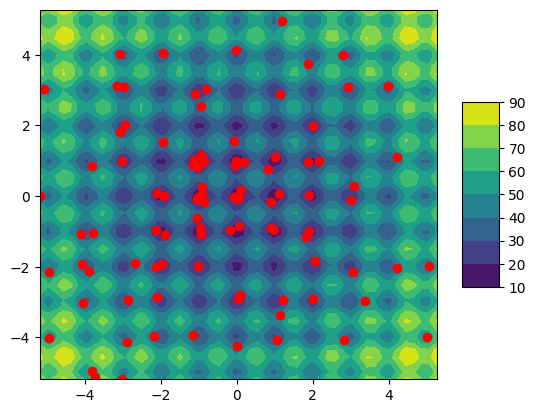

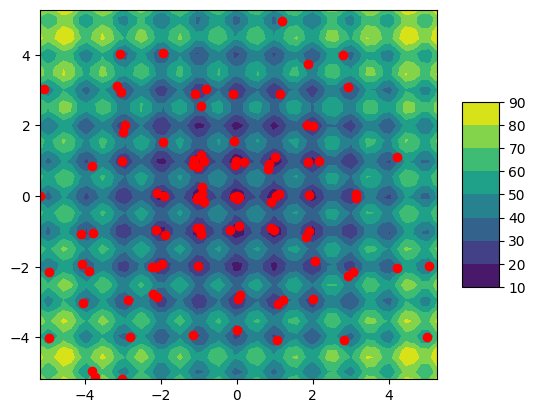

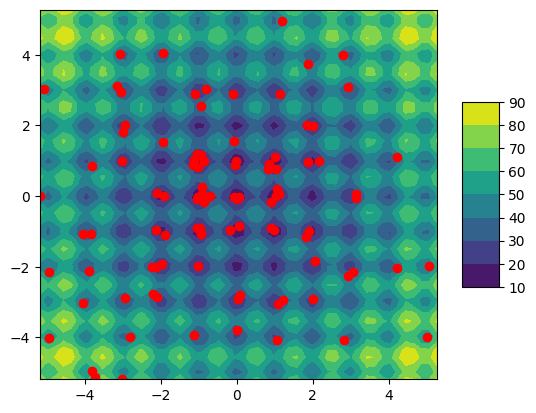

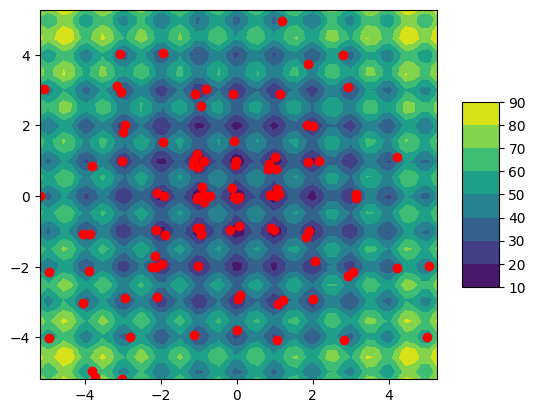

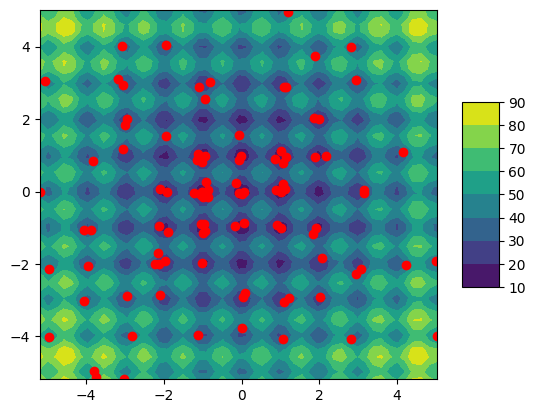

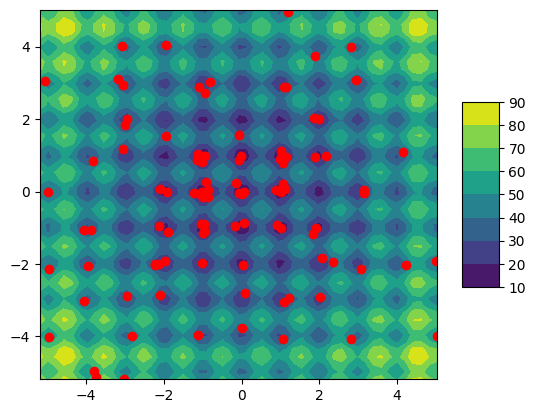

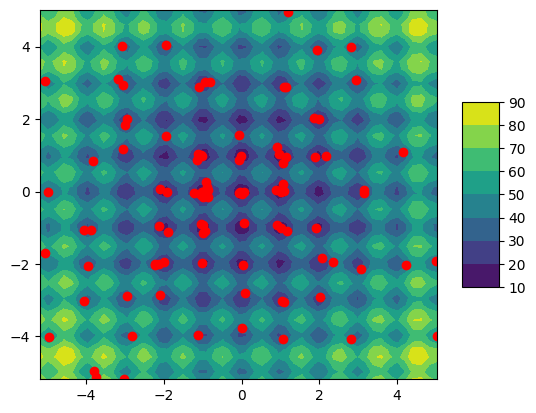

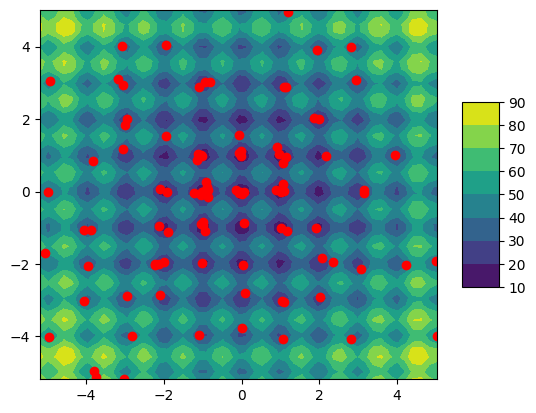

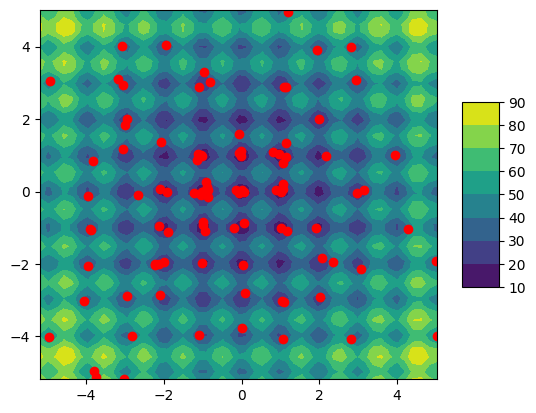

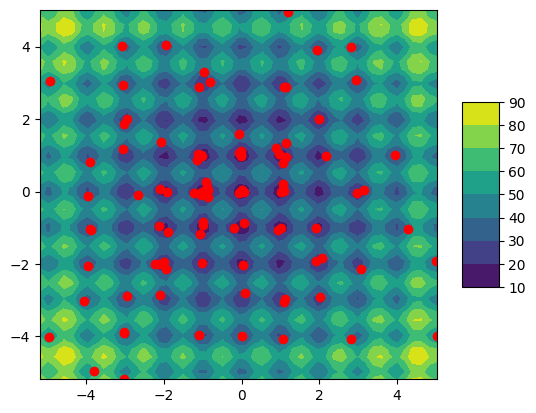

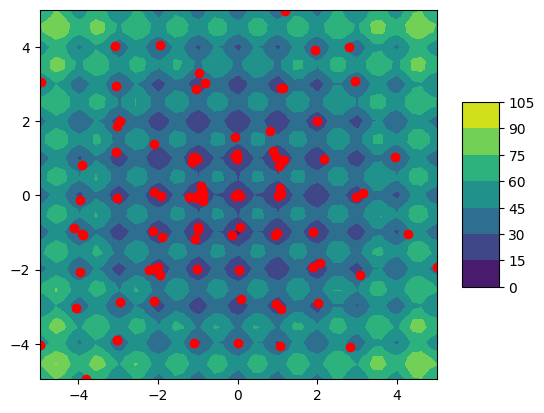

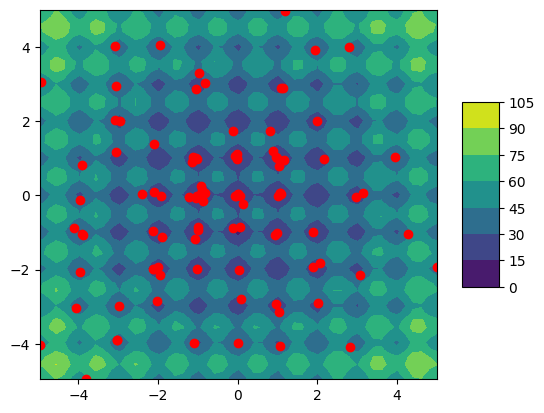

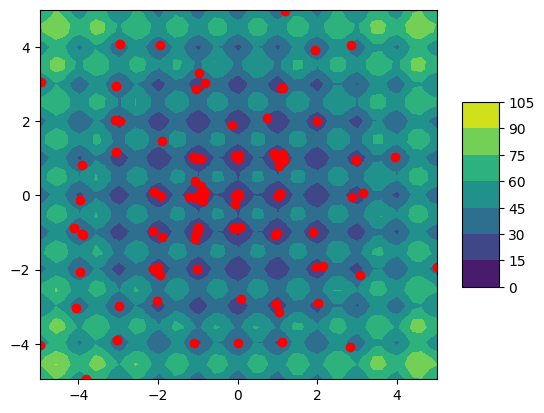

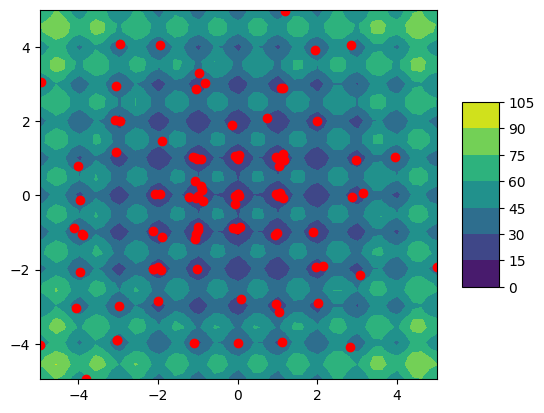

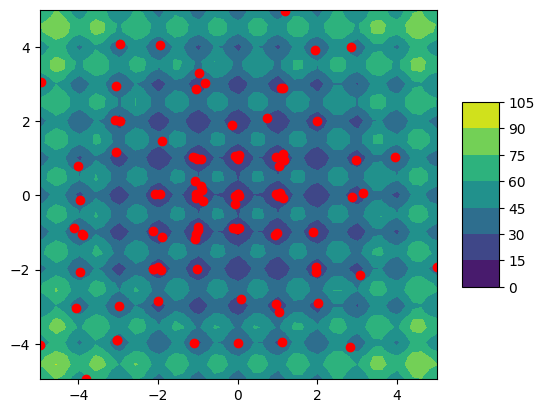

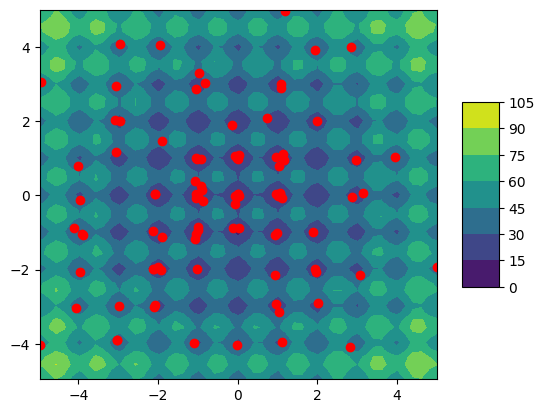

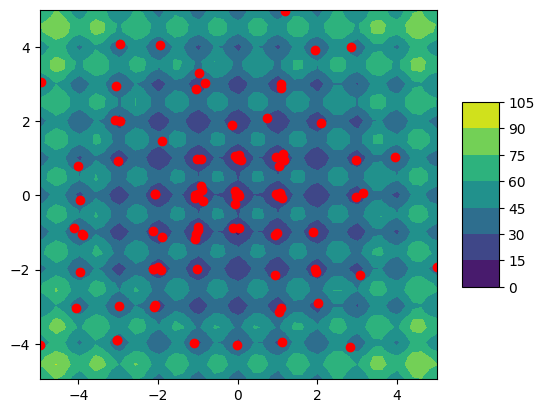

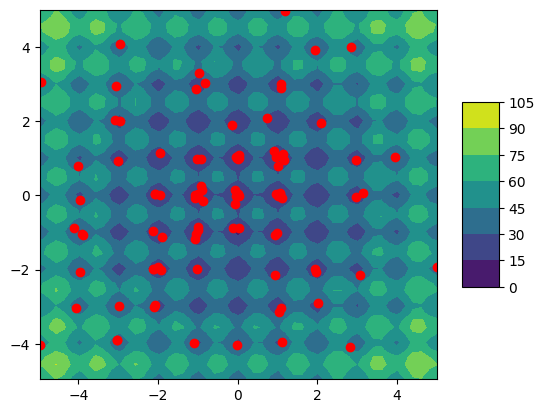

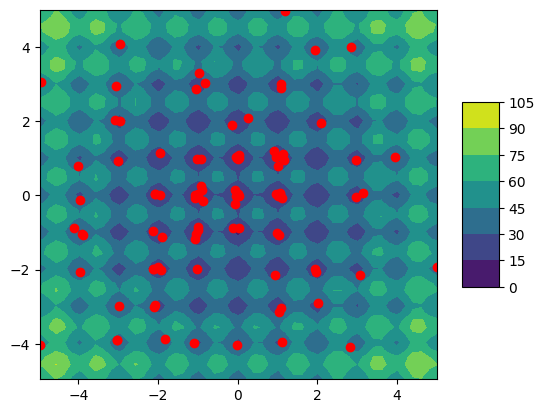

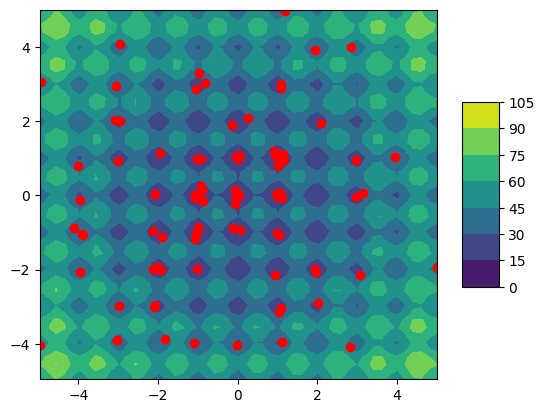

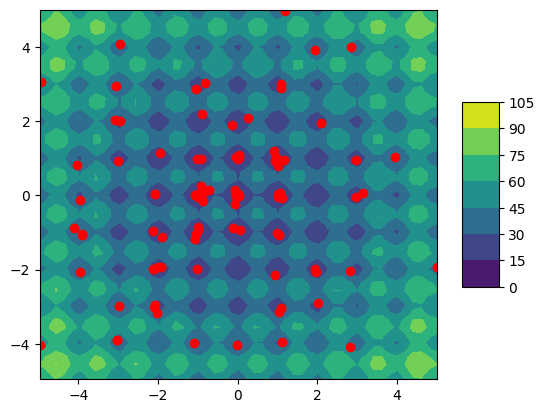

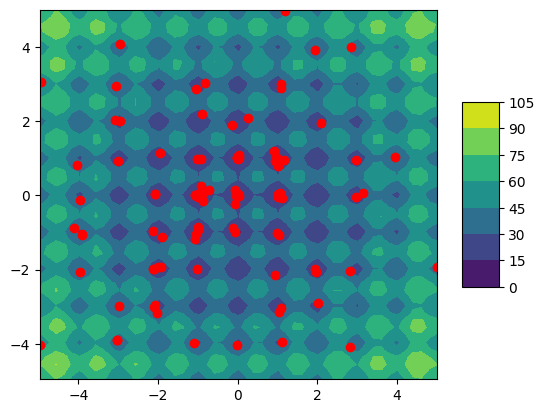

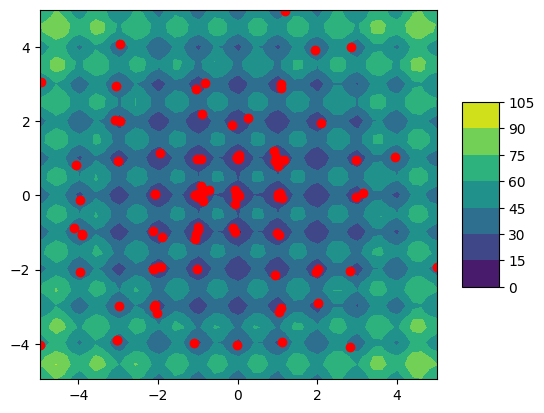

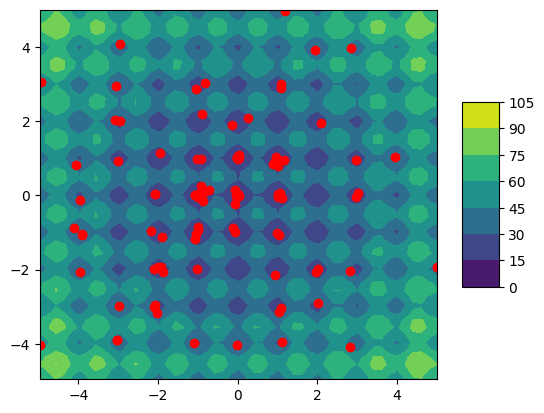

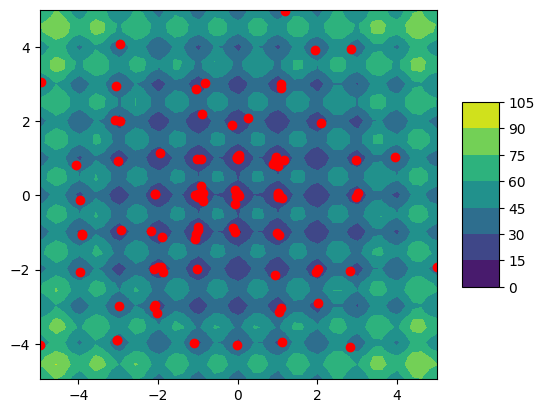

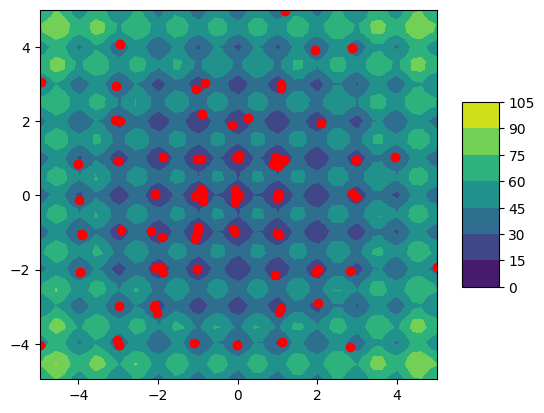

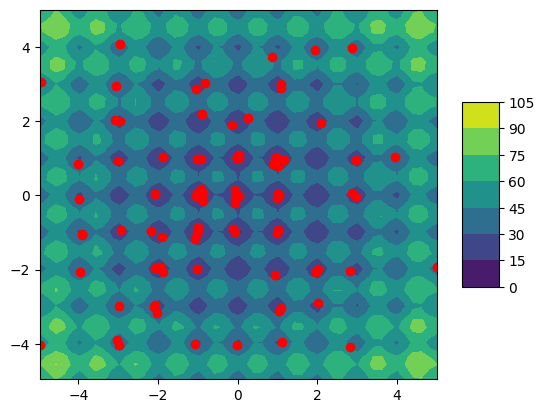

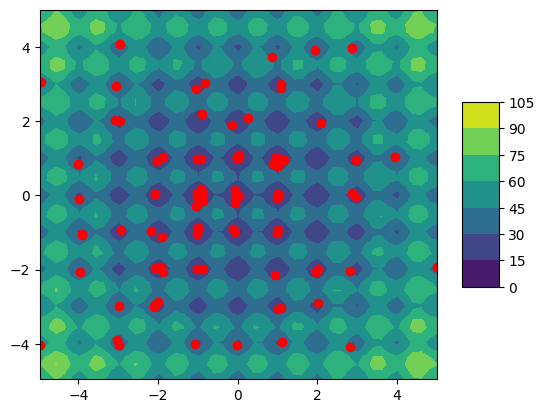

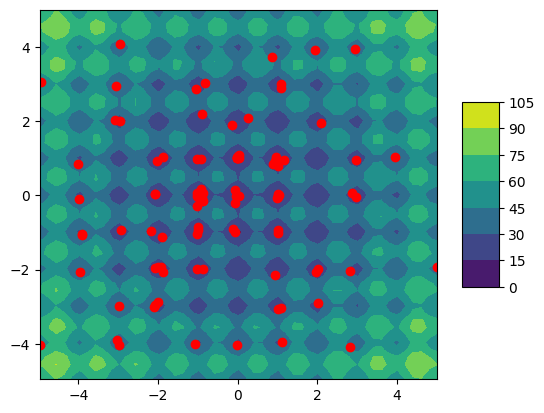

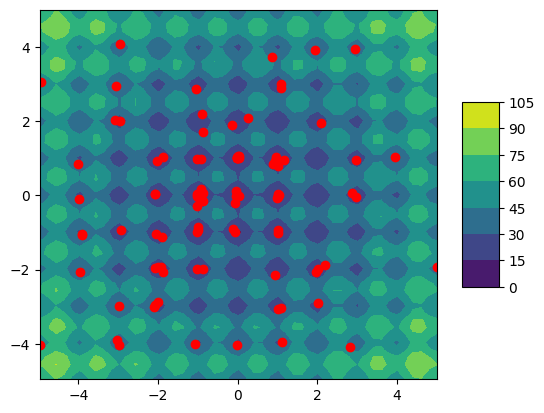

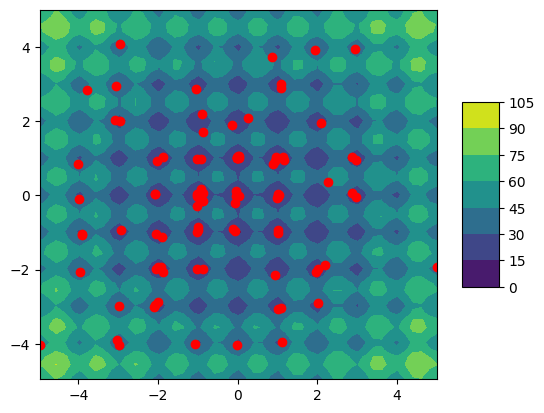

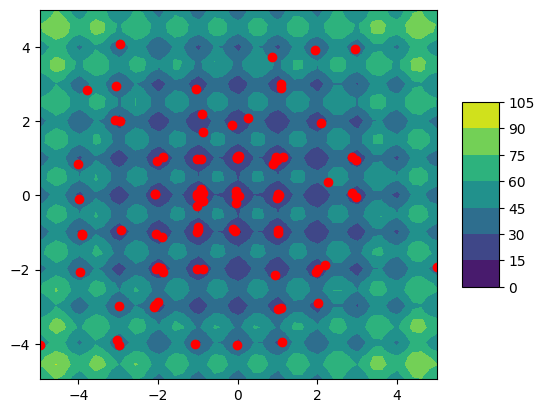

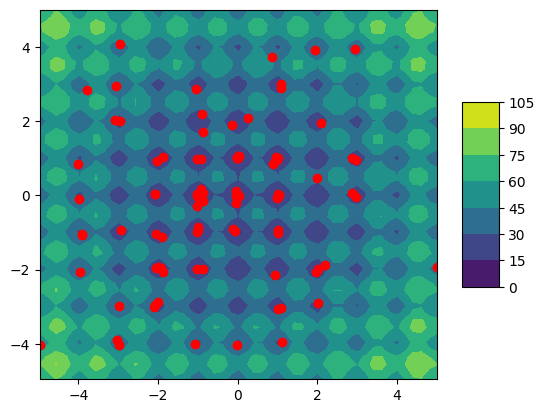

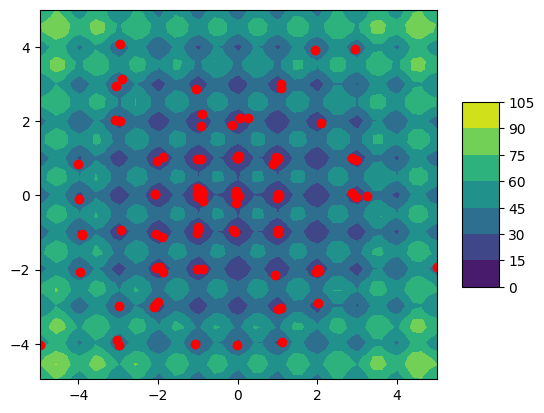

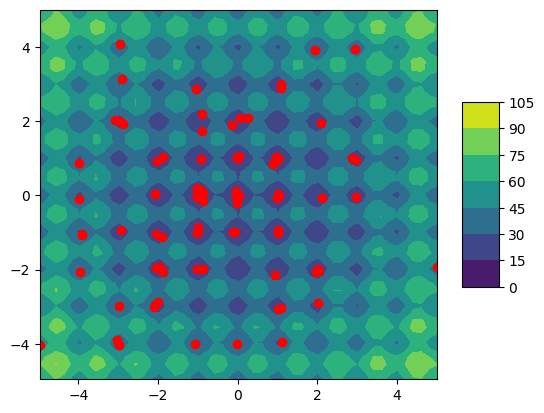

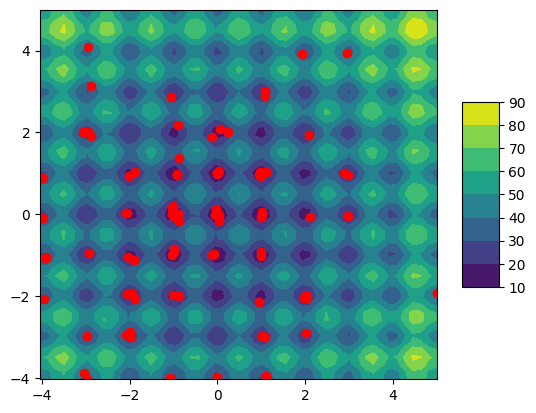

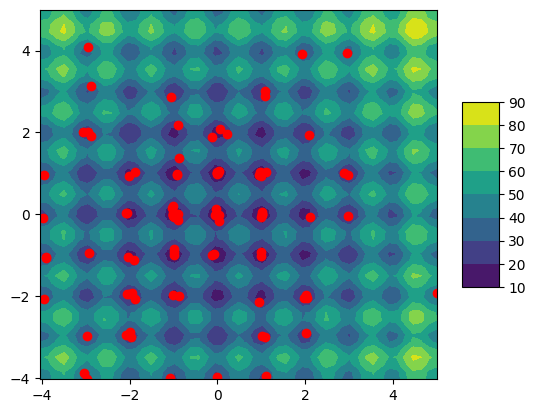

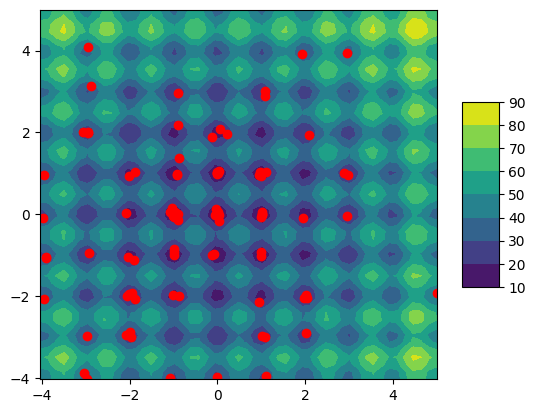

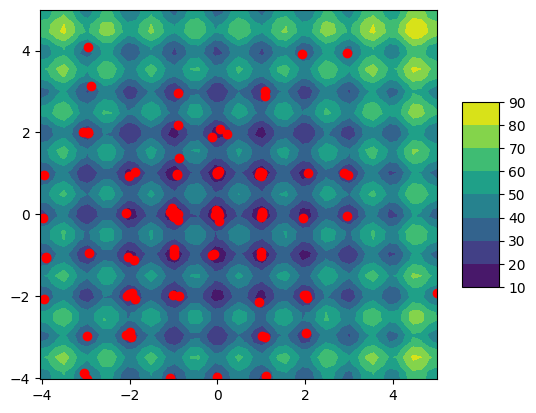

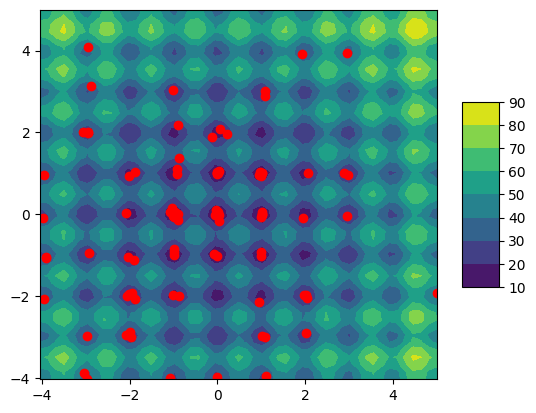

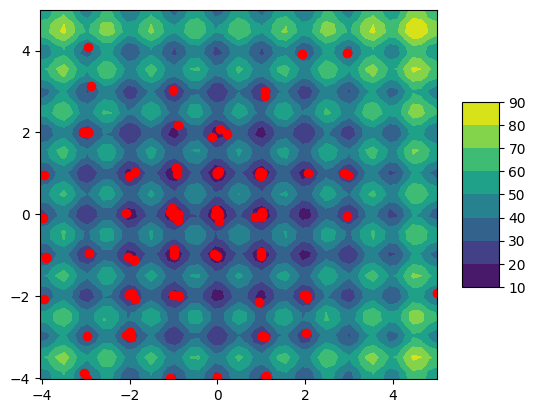

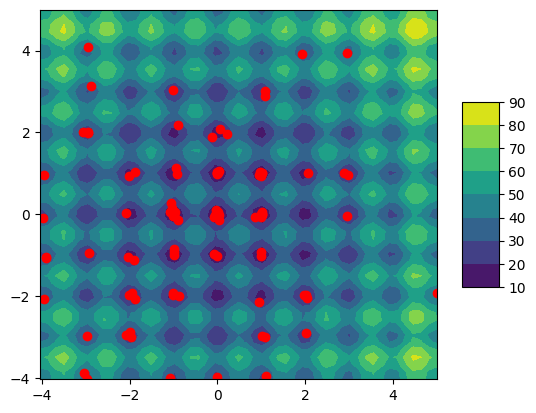

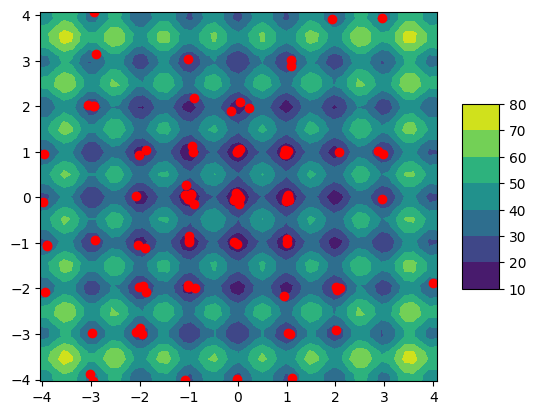

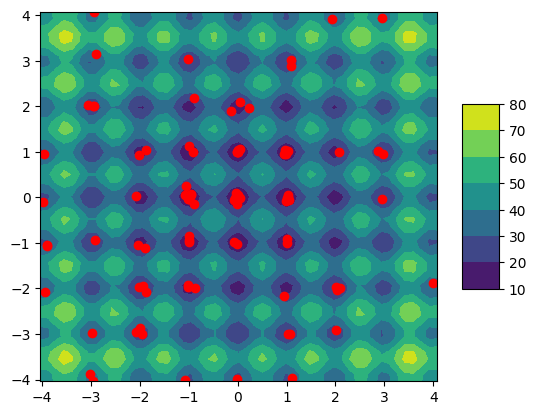

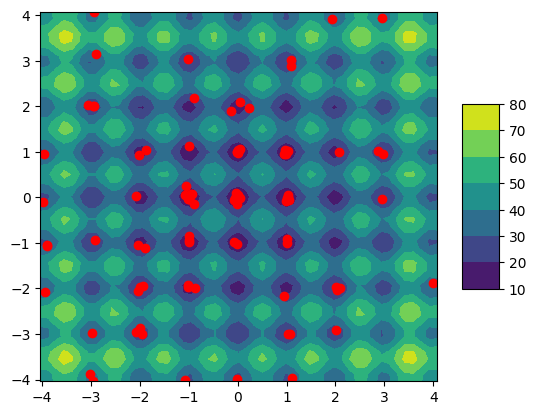

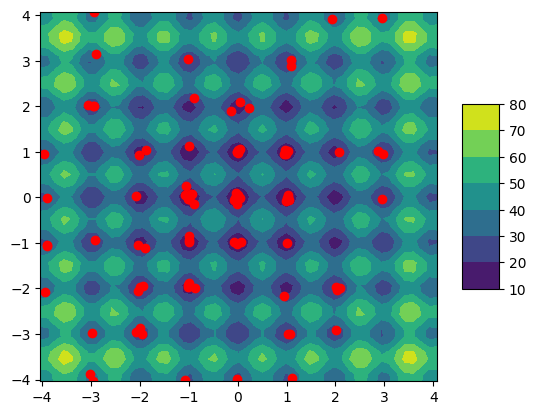

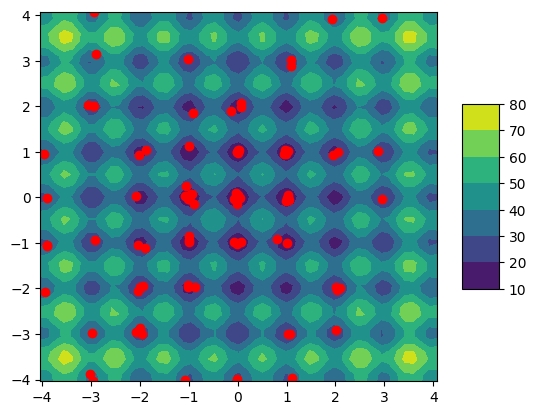

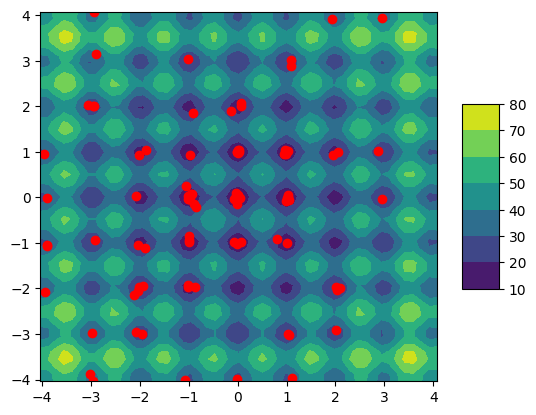

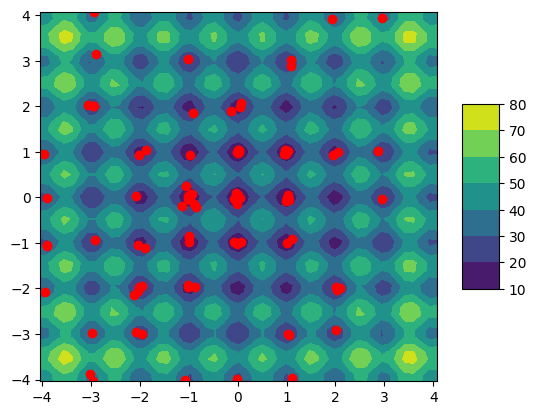

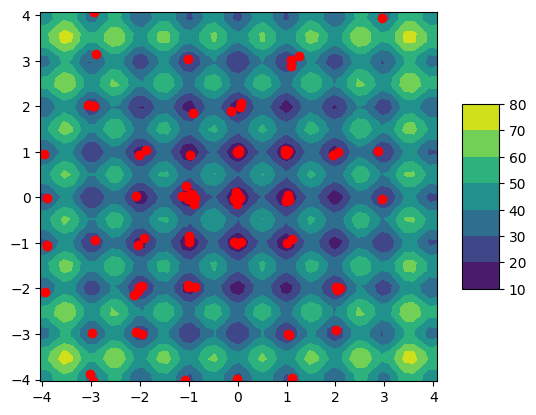

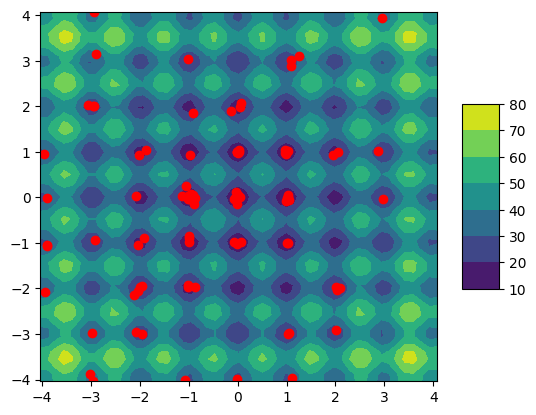

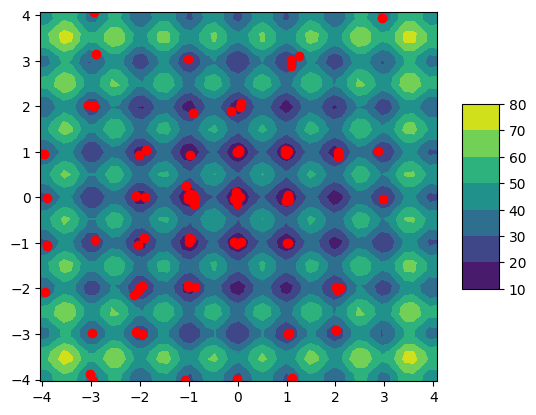

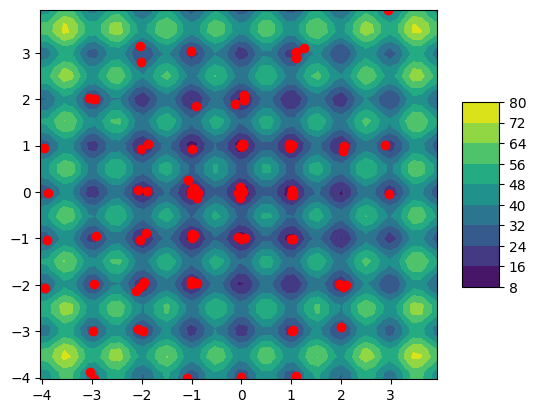

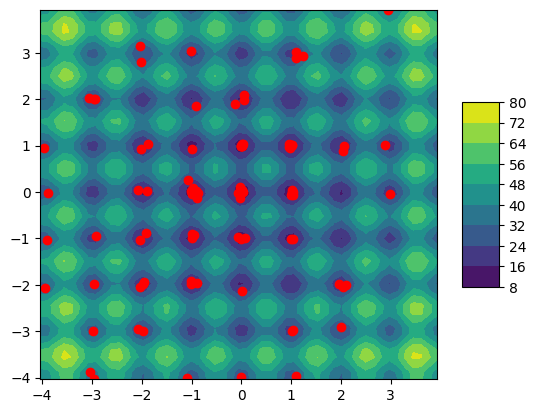

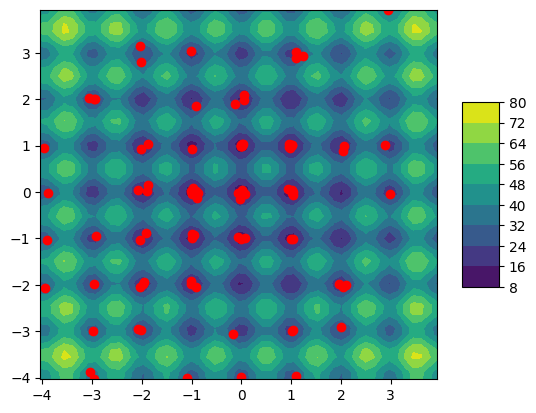

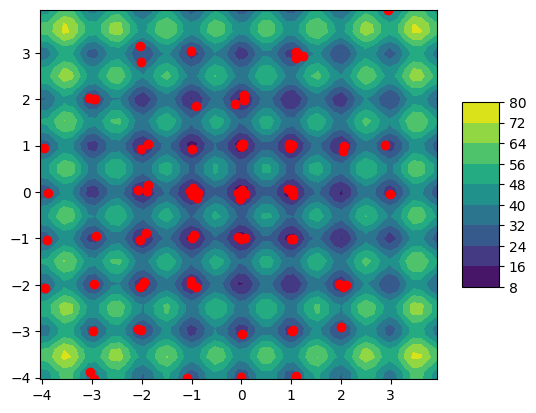

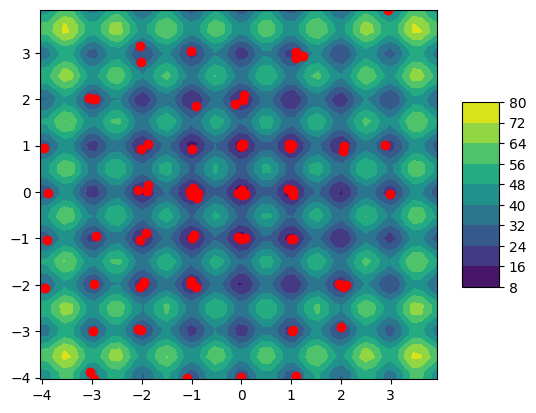

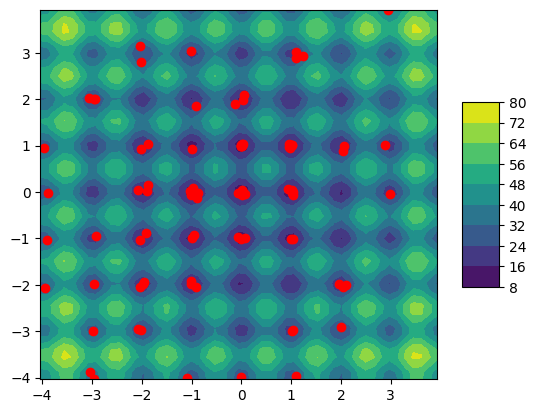

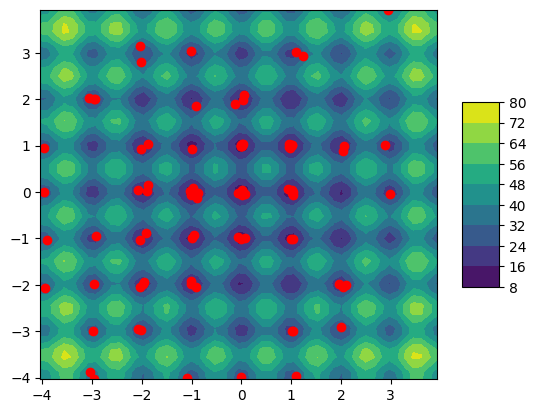

['At iteration 100.0 the best fitness is 0.16222539523658241']
Координаты лучшего агента: [0.01584407 0.02123098 0.01080866]


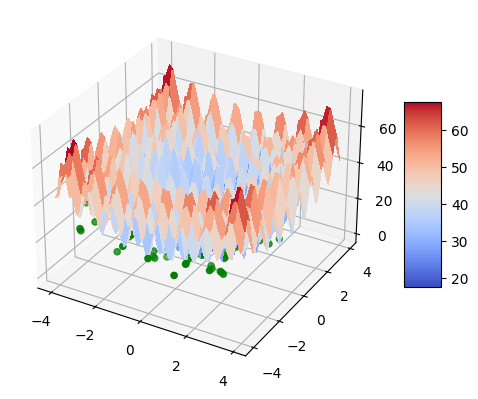

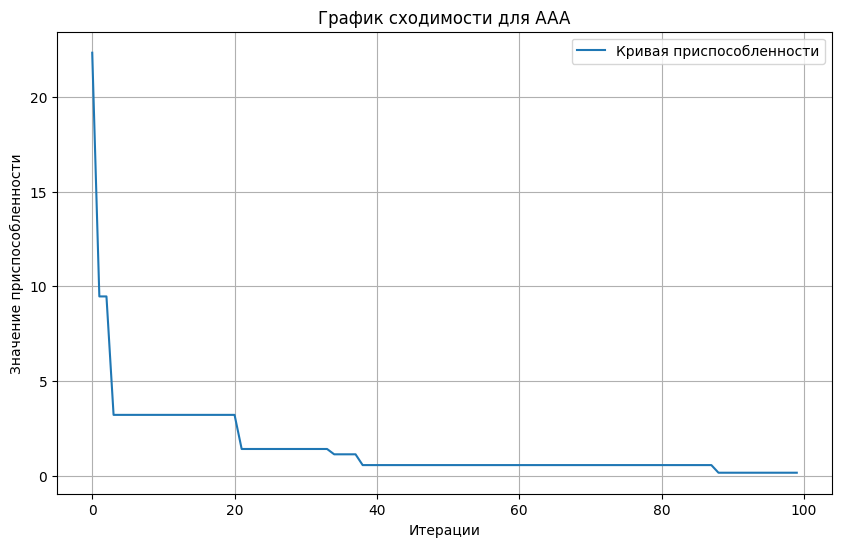

In [36]:
x=AAA(rastrigin_wrapper, lb = -5.12, ub = 5.12 ,dim = 3,SearchAgents_no = 100 ,Max_iter = 100, testing_function=Rastrigin(dim = 3), s_force= 0.42, e_loss= 0.27, ap = 0.46)

#### Запуск алгоритма с функцией Химмельблау:

<img src="image/7.png">

AAA is optimizing  "himmelblau_wrapper"


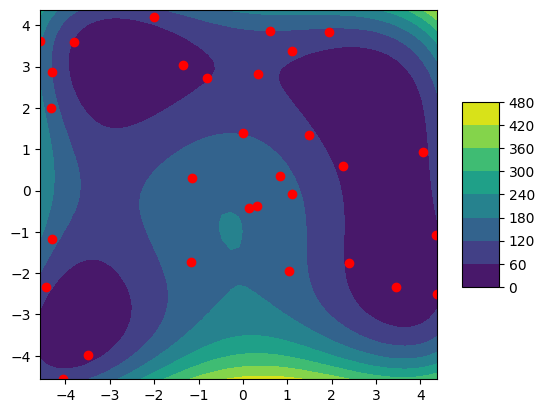

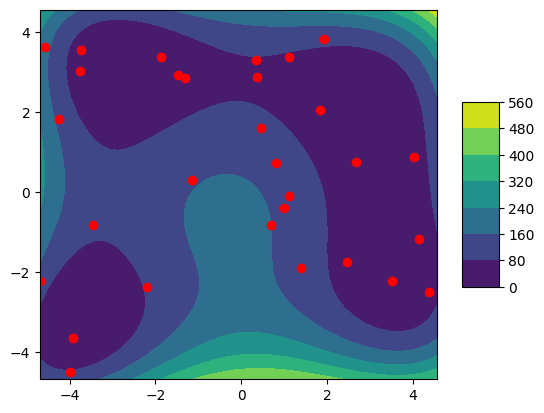

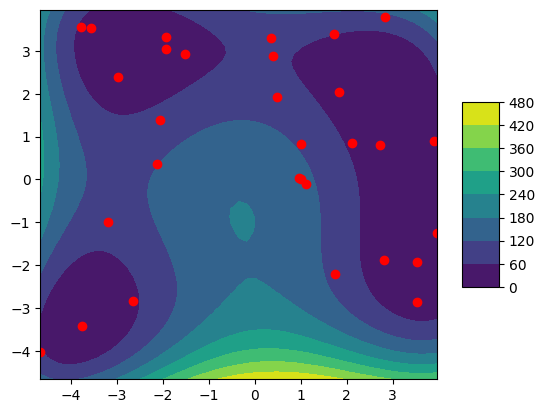

['At iteration 10.0 the best fitness is 0.20892223085563177']
Координаты лучшего агента: [ 3.53791162 -1.91842276  2.03973585]


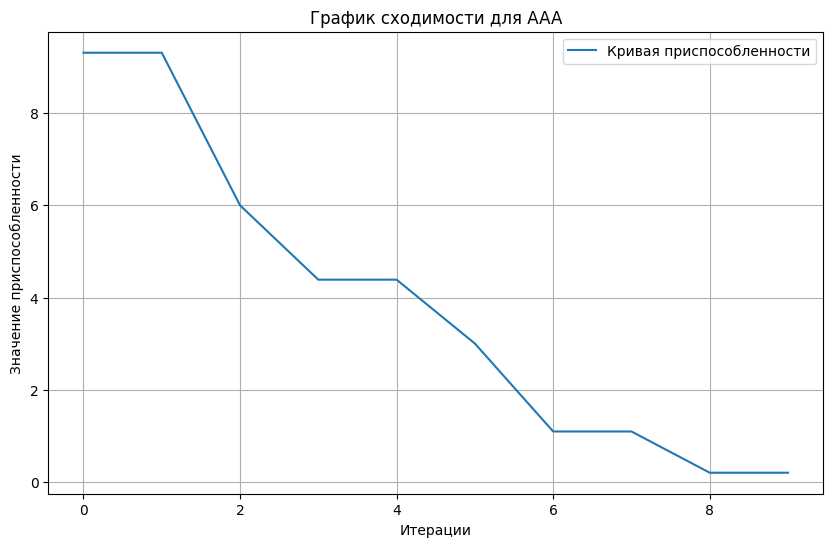

In [66]:
x=AAA(himmelblau_wrapper, lb = -5,ub = 5,dim = 3,SearchAgents_no = 30 ,Max_iter= 10, testing_function=Himmelblau(), s_force= 0.9, e_loss= 0.45, ap = 0.6)

#### Запуск алгоритма с функцией Розенброка:

<img src="image/9.png">

AAA is optimizing  "rosenbrock_wrapper"


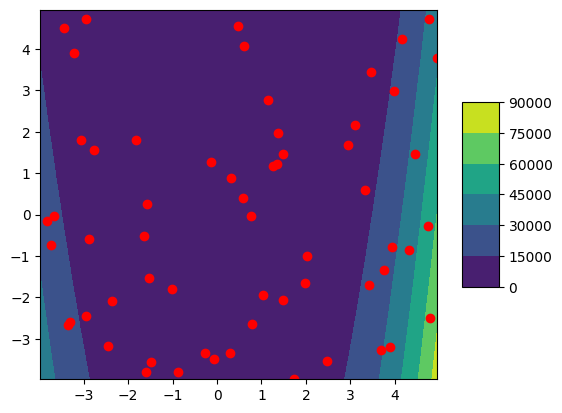

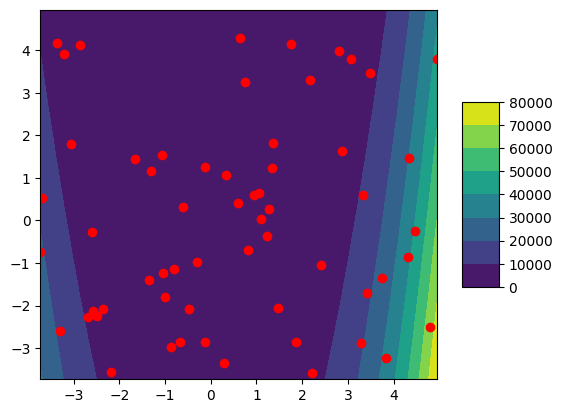

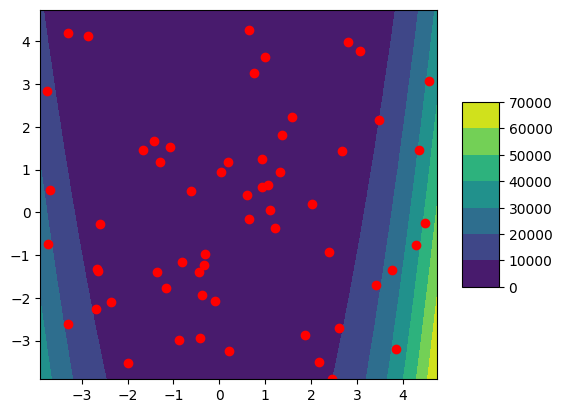

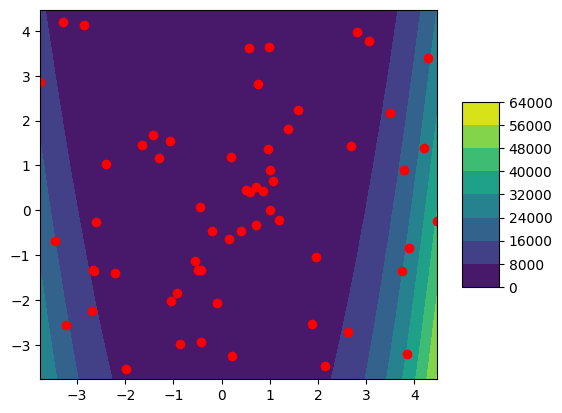

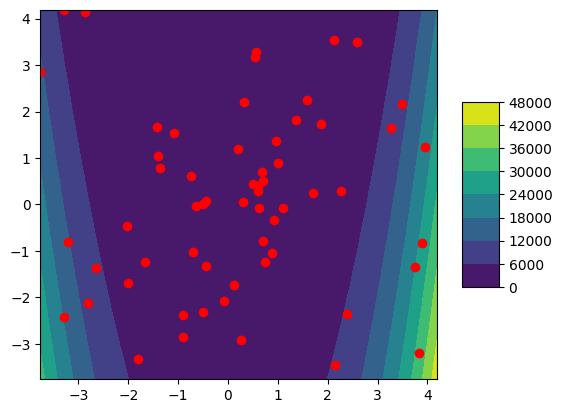

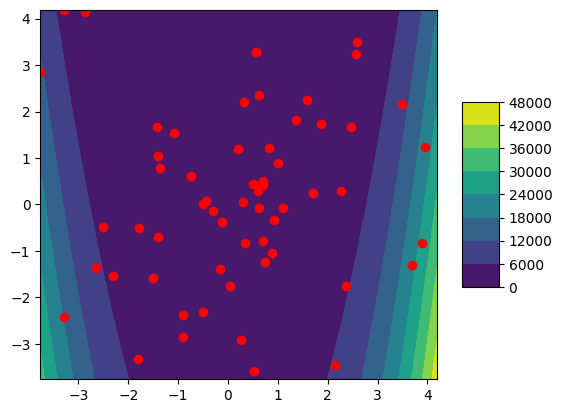

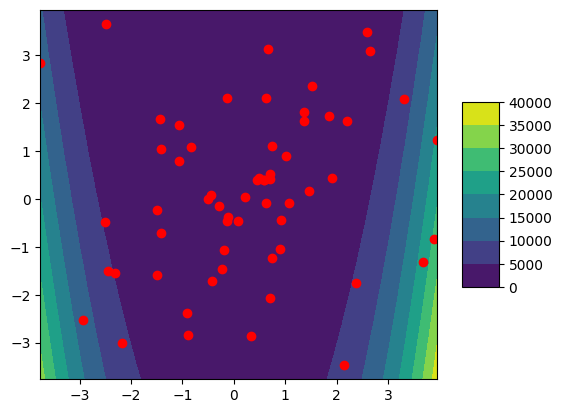

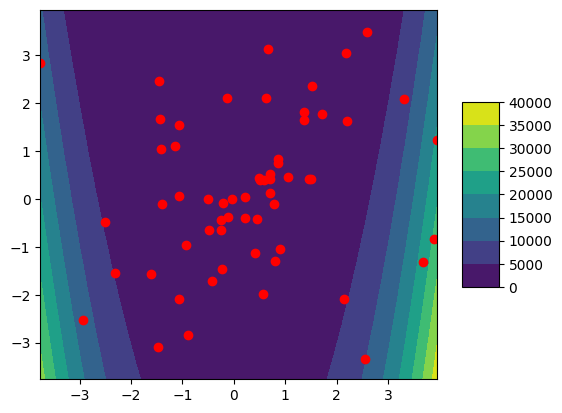

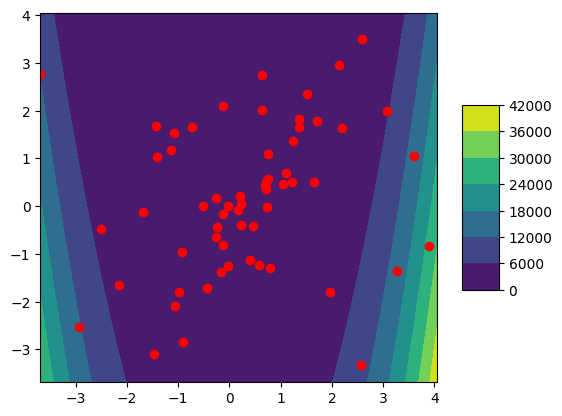

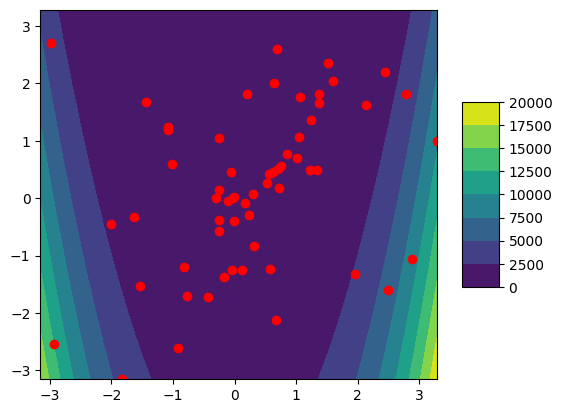

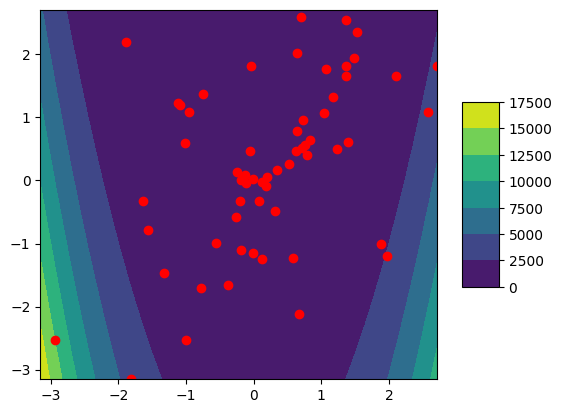

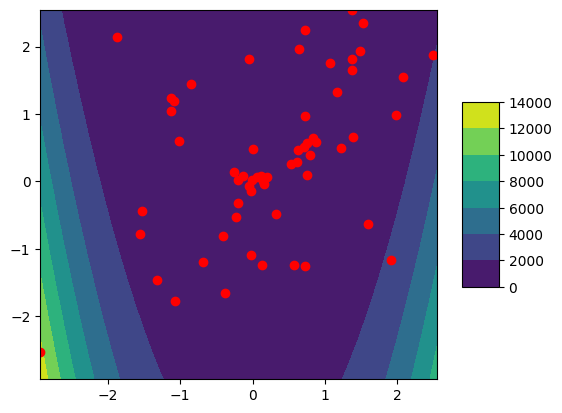

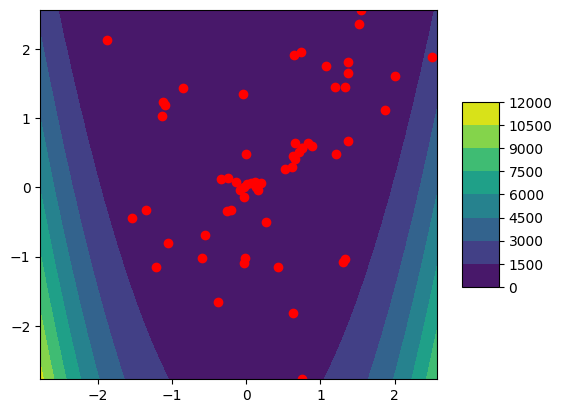

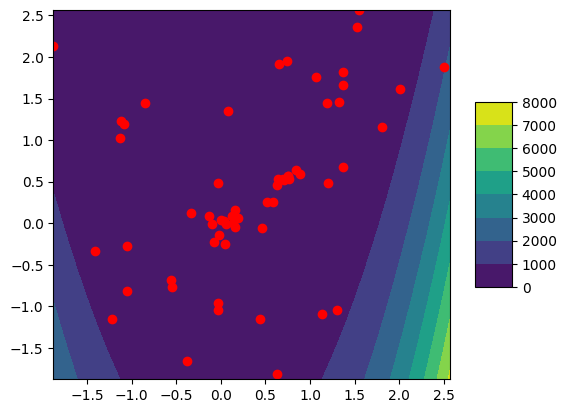

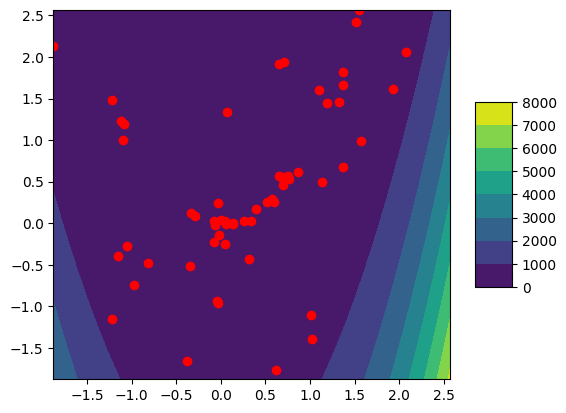

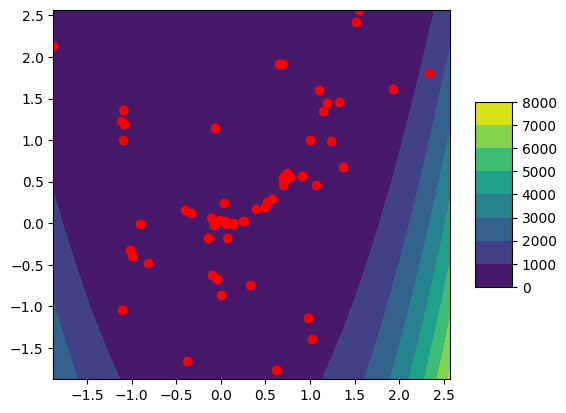

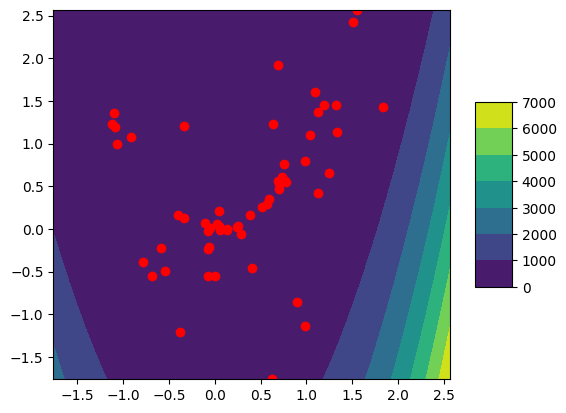

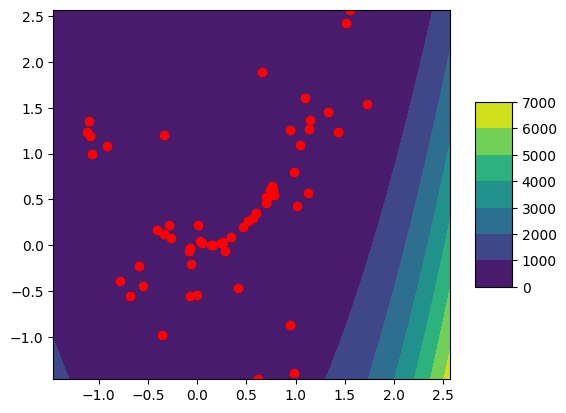

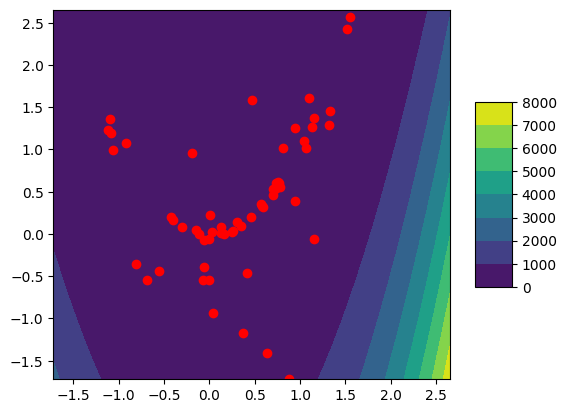

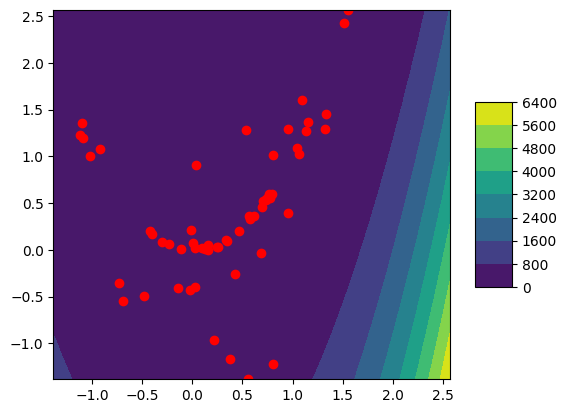

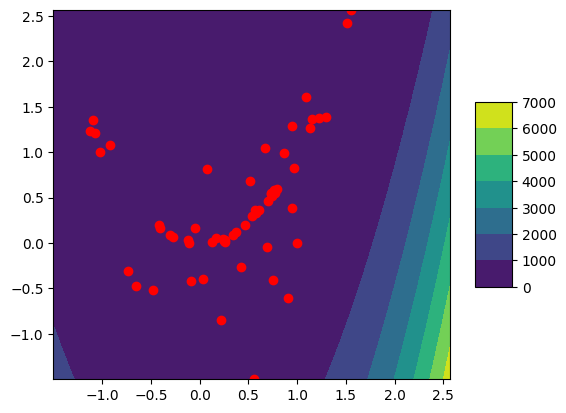

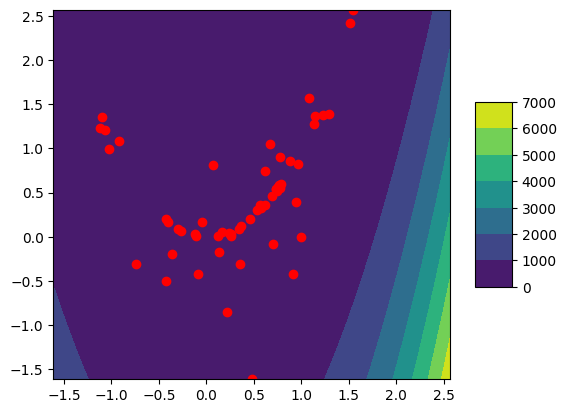

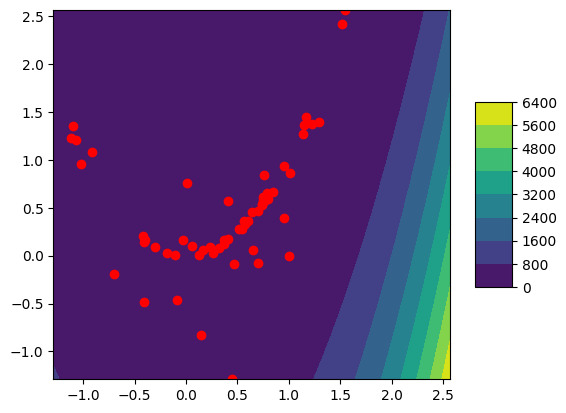

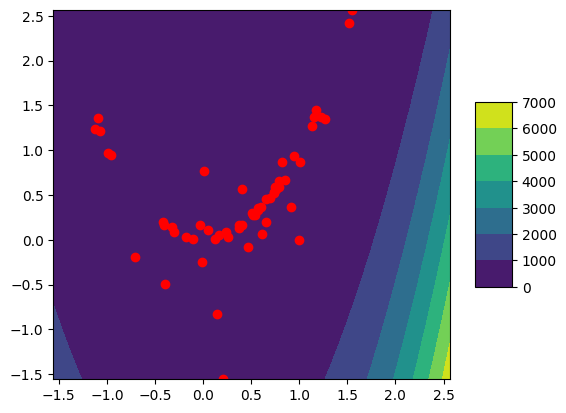

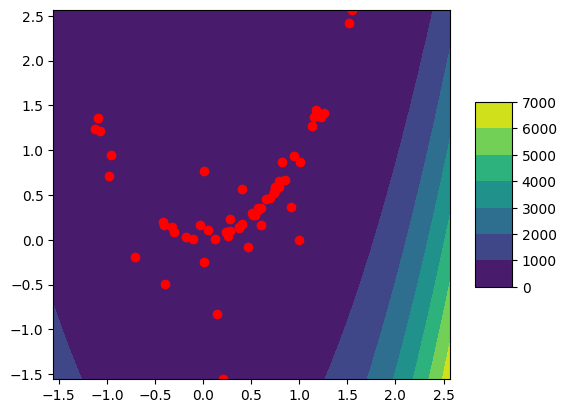

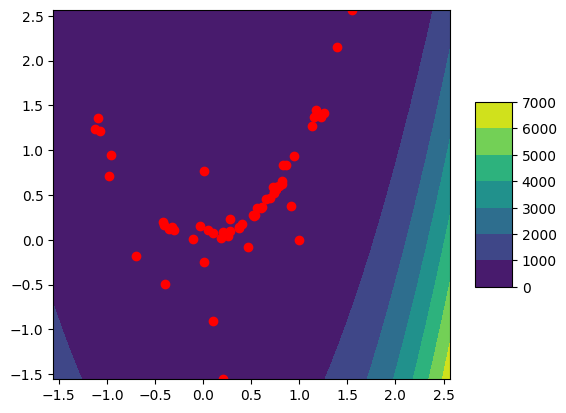

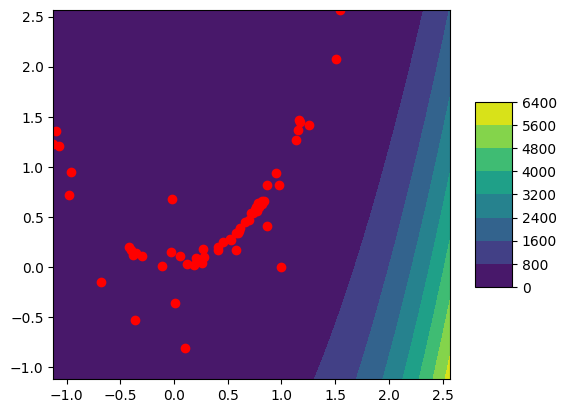

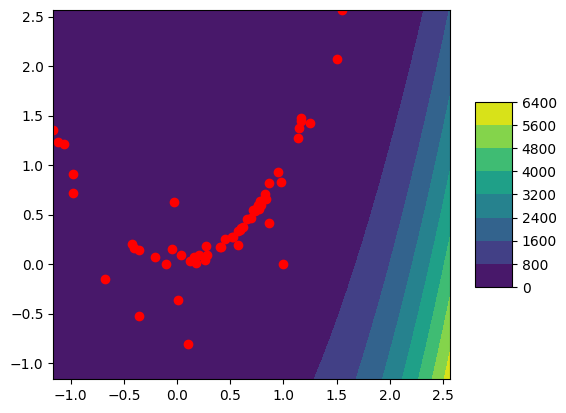

['At iteration 80.0 the best fitness is 0.10443842393100031']
Координаты лучшего агента: [0.94985492 0.93324026 0.86737584]


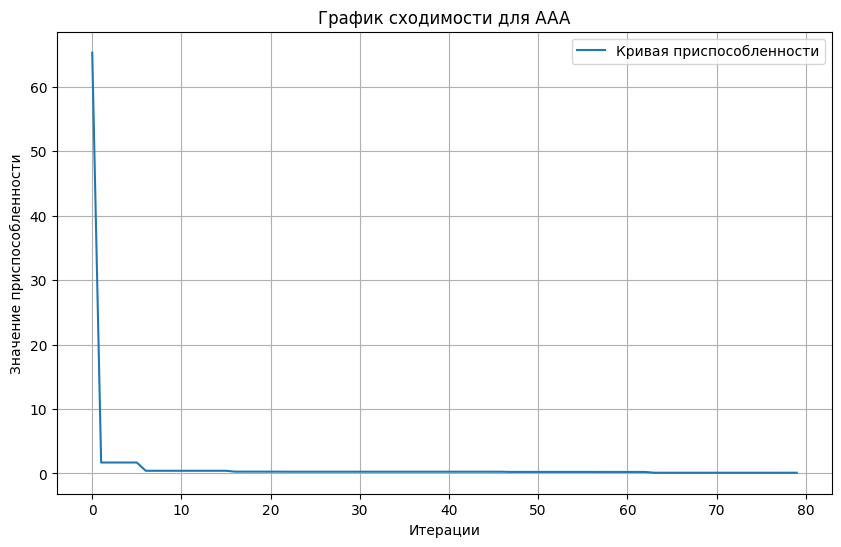

In [38]:
x=AAA(rosenbrock_wrapper, lb = -4,ub = 5,dim = 3,SearchAgents_no = 60 ,Max_iter= 80, testing_function=Rosenbrock(), s_force= 0.56, e_loss= 0.45, ap = 0.12)


#### Запуск алгоритма с функцией "Подставки для яиц":

<img src="image/11.png">

AAA is optimizing  "egg_holder_wrapper"


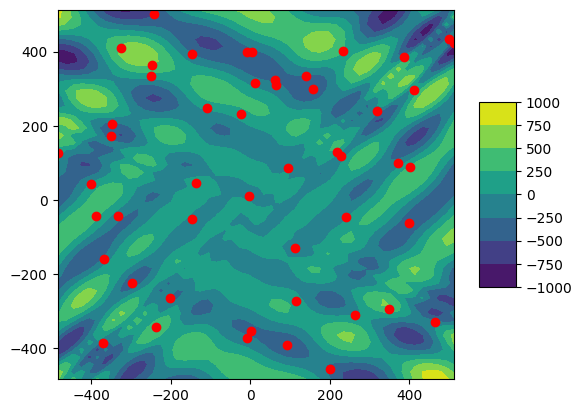

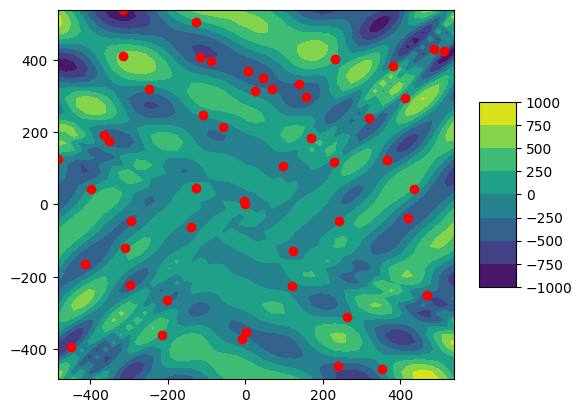

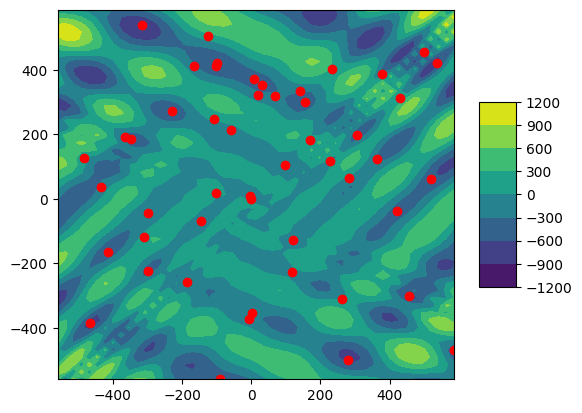

['At iteration 10.0 the best fitness is -916.7550750266262']
Координаты лучшего агента: [ 536.65957825  421.41953943 -316.25344001]


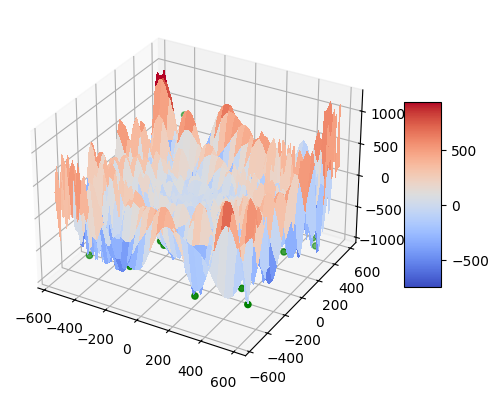

In [53]:
x=AAA(egg_holder_wrapper, lb = -512,ub = 512,dim = 3, SearchAgents_no = 50 ,Max_iter= 10, testing_function=EggHolder(), s_force= 0.8, e_loss = 0.1, ap= 0.9)


### Анализ результатов

#### В процессе вычисления лучших гиперпараметров для целевых функций, воспользовались библиотекой 'Optuna'.
#### Для записи вычисленных значений использовали  библиотеку pandas

#### Вычисление гиперпараметров для функции Растригина:

In [54]:
def objective(trial):
    SearchAgents_no = trial.suggest_int('SearchAgents_no', 10, 100, step=10)
    Max_iter = trial.suggest_int('Max_iter', 10, 100, step=10)
    s_force = trial.suggest_discrete_uniform('s_force', 0.1, 1.0, 0.1)
    e_loss = trial.suggest_discrete_uniform('e_loss', 0.01, 1.0, 0.02)
    ap = trial.suggest_discrete_uniform('ap', 0.1, 1.0, 0.1)

    result = AAA(rastrigin_wrapper, lb=-5.12, ub=5.12, dim=3, 
                 SearchAgents_no=int(SearchAgents_no), Max_iter=int(Max_iter), 
                 s_force=s_force, e_loss=e_loss, ap=ap, 
                 testing_function=Rastrigin(dim = 3))
    
    return result.objective_value  

# Создание исследования и его оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Сохраняем детали всех испытаний в DataFrame
df = study.trials_dataframe()

# Добавляем лучшие параметры и результат в DataFrame
best_params = study.best_params
best_value = study.best_value
best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

# Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
best_params_df = pd.DataFrame([best_params])
best_params_df['record_type'] = 'best_result'
df = pd.concat([df, best_params_df], ignore_index=True)

# Записываем DataFrame в CSV файл
df.to_csv('csv_files/rastrigin.csv', index=False)




#### Вычисление гиперпараметров для функции Химмельблау:

In [55]:
# def objective(trial):
#     SearchAgents_no = trial.suggest_int('SearchAgents_no', 10, 100, step=10)
#     Max_iter = trial.suggest_int('Max_iter', 10, 100, step=10)
#     s_force = trial.suggest_discrete_uniform('s_force', 0.1, 1.0, 0.1)
#     e_loss = trial.suggest_discrete_uniform('e_loss', 0.01, 1.0, 0.02)
#     ap = trial.suggest_discrete_uniform('ap', 0.1, 1.0, 0.1)

#     result = AAA(himmelblau_wrapper, lb=-5, ub=5, dim=3, 
#                  SearchAgents_no=int(SearchAgents_no), Max_iter=int(Max_iter), 
#                  s_force=s_force, e_loss=e_loss, ap=ap, 
#                  testing_function=Himmelblau())
    
#     return result.objective_value  

# # Создание исследования и его оптимизация
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# # Сохраняем детали всех испытаний в DataFrame
# df = study.trials_dataframe()

# # Добавляем лучшие параметры и результат в DataFrame
# best_params = study.best_params
# best_value = study.best_value
# best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/himmelblau.csv', index=False)


#### Вычисление гиперпараметров для функции Розенброка:

In [56]:
# def objective(trial):
#     # Параметры поисковых агентов и максимальное количество итераций
#     SearchAgents_no = trial.suggest_int('SearchAgents_no', 10, 100, step=10)
#     Max_iter = trial.suggest_int('Max_iter', 10, 100, step=10)

#     # Параметры для алгоритма
#     s_force = trial.suggest_discrete_uniform('s_force', 0.1, 1.0, 0.02)
#     e_loss = trial.suggest_discrete_uniform('e_loss', 0.01, 1.0, 0.02)
#     ap = trial.suggest_discrete_uniform('ap', 0.1, 1.0, 0.02)

#     # Параметры для границ поиска
#     lb = trial.suggest_float('lb', -100, 0, step=10)
#     ub = trial.suggest_float('ub', 0, 100, step=10)

#     # Вызов оптимизируемой функции
#     result = AAA(rosenbrock_wrapper, lb=lb, ub=ub, dim=3, 
#                 SearchAgents_no=int(SearchAgents_no), Max_iter=int(Max_iter), 
#                 s_force=s_force, e_loss=e_loss, ap=ap, 
#                 testing_function=Rosenbrock())

#     return result.objective_value  

# # Создание исследования и его оптимизация
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# # Сохраняем детали всех испытаний в DataFrame
# df = study.trials_dataframe()

# # Добавляем лучшие параметры и результат в DataFrame
# best_params = study.best_params
# best_value = study.best_value
# best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/rosenbrock.csv', index=False)



#### Вычисление гиперпараметров для функции "Подставки для яиц" (Egg_Holder):

In [57]:
# def objective(trial):
#     SearchAgents_no = trial.suggest_int('SearchAgents_no', 10, 60, step=10)
#     Max_iter = trial.suggest_int('Max_iter', 10, 60, step=10)
#     s_force = trial.suggest_discrete_uniform('s_force', 0.1, 1.0, 0.1)
#     e_loss = trial.suggest_discrete_uniform('e_loss', 0.01, 1.0, 0.02)
#     ap = trial.suggest_discrete_uniform('ap', 0.1, 1.0, 0.1)

#     result = AAA(egg_holder_wrapper, lb=-512, ub=512, dim=3, 
#                  SearchAgents_no=int(SearchAgents_no), Max_iter=int(Max_iter), 
#                  s_force=s_force, e_loss=e_loss, ap=ap, 
#                  testing_function=EggHolder())
    
#     return result.objective_value  

# # Создание исследования и его оптимизация
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# # Сохраняем детали всех испытаний в DataFrame
# df = study.trials_dataframe()

# # Добавляем лучшие параметры и результат в DataFrame
# best_params = study.best_params
# best_value = study.best_value
# best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/eggholder.csv', index=False)



#### Полученные значение приведены ниже в таблице с указанием в конце наилучшего результата:

#### Гиперпараметры для функции Растригина:

In [67]:
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/rastrigin.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_Max_iter', 'params_SearchAgents_no',
    'params_ap', 'params_e_loss', 'params_s_force',  'SearchAgents_no', 
    'Max_iter', 's_force', 'e_loss', 'ap', 'best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))


+------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+--------+--------------+---------------+
|      | datetime_start             | datetime_complete          |   params_Max_iter |   params_SearchAgents_no |   params_ap |   params_e_loss |   params_s_force |   SearchAgents_no |   Max_iter |   s_force |   e_loss |     ap |   best_value | record_type   |
|------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+--------+--------------+---------------|
|    0 | 2024-04-12 12:50:48.727690 | 2024-04-12 12:50:49.300689 |               100 |                      100 |        0.46 |            0.27 |             0.42 |               nan |        nan |    nan    |   nan  

#### Лучшие гиперпараметры для функции Химмельблау:

In [68]:
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/himmelblau.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_Max_iter', 'params_SearchAgents_no',
    'params_ap', 'params_e_loss', 'params_s_force',  'SearchAgents_no', 
    'Max_iter', 's_force', 'e_loss', 'ap', 'best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))


+------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+-------+--------------+---------------+
|      | datetime_start             | datetime_complete          |   params_Max_iter |   params_SearchAgents_no |   params_ap |   params_e_loss |   params_s_force |   SearchAgents_no |   Max_iter |   s_force |   e_loss |    ap |   best_value | record_type   |
|------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+-------+--------------+---------------|
|    0 | 2024-04-12 12:54:56.113401 | 2024-04-12 12:54:56.288406 |                60 |                       80 |        0.74 |            0.01 |             0.4  |               nan |        nan |     nan   |   nan    |

#### Лучшие гиперпараметры для функции Розенброка:

In [70]:
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/rosenbrock.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_Max_iter', 'params_SearchAgents_no',
    'params_ap', 'params_e_loss', 'params_s_force',  'SearchAgents_no', 
    'Max_iter', 's_force', 'e_loss', 'ap', 'best_value', 'record_type', 'params_lb', 'params_ub', 'lb', 'ub'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))


+------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+--------+--------------+---------------+-------------+-------------+------+------+
|      | datetime_start             | datetime_complete          |   params_Max_iter |   params_SearchAgents_no |   params_ap |   params_e_loss |   params_s_force |   SearchAgents_no |   Max_iter |   s_force |   e_loss |     ap |   best_value | record_type   |   params_lb |   params_ub |   lb |   ub |
|------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+--------+--------------+---------------+-------------+-------------+------+------|
|    0 | 2024-04-12 12:57:59.418109 | 2024-04-12 12:57:59.591086 |                30 |     

#### Лучшие гиперпараметры для функции Подставки для яиц(Egg_holder):

In [71]:
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/eggholder.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_Max_iter', 'params_SearchAgents_no',
    'params_ap', 'params_e_loss', 'params_s_force',  'SearchAgents_no', 
    'Max_iter', 's_force', 'e_loss', 'ap', 'best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))


+------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+-------+--------------+---------------+
|      | datetime_start             | datetime_complete          |   params_Max_iter |   params_SearchAgents_no |   params_ap |   params_e_loss |   params_s_force |   SearchAgents_no |   Max_iter |   s_force |   e_loss |    ap |   best_value | record_type   |
|------+----------------------------+----------------------------+-------------------+--------------------------+-------------+-----------------+------------------+-------------------+------------+-----------+----------+-------+--------------+---------------|
|    0 | 2024-04-12 14:54:47.017779 | 2024-04-12 14:54:47.039776 |                20 |                       20 |         0.4 |            0.67 |              0.9 |               nan |        nan |     nan   |    nan   |

#### Анализ полученных данных:

Различные алгоритмы оптимизации работают с различной эффективностью на разных функциях. 
В случае оптимизации функции Растригина, функции Химмельблау и функции Розенброка можно сказать, что алгоритм нашел необходимые глобальные минимумы
тогда как для функции Подставки для яиц требуется более гибкая настройка гиперпараметров для достижения аналогичного уровня точности. 

#### Источники: 

- https://www.sci-hub.ru/10.1016/j.asoc.2015.03.003 (статья)
- https://optuna.readthedocs.io/en/stable/ (использование optunа для оптимизхации гиперпараметров)